# Analyzing Company Lifespan and Termination Factors Using Survival Analysis and Hazard Models





#### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from itertools import combinations

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test, logrank_test, multivariate_logrank_test
 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

from statsmodels.stats.multitest import multipletests

from datetime import datetime



#### Load company data

In [2]:
# Prevent truncation of columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to the next line

file_path = 'data/all_companies_20241207.csv'
cvr_df =  pd.read_csv(file_path, sep=None, engine='python', on_bad_lines='skip')
cvr_df_original = cvr_df.copy()
cvr_df.head()

,cvr_nummer,cvr_id,company_status,industry_code,company_type,incorporation_date,termination__date,lifespan_months,number_of_names,number_of_primary_industry_codes,number_of_owners,num_statement_submitters,num_statements,mean_equity,std_equity,mean_staff_expenses,std_staff_expenses,mean_result,std_result,num_addresses,num_employees_year,num_employees,owner_num_prev_companies,owner_num_prev_companies_dissolved,owner_num_prev_bancruptcies,one_person_has_all_roles,coowned_by_company,coowned_by_holding_company,executive_num_prev_companies,executive_num_prev_companies_dissolved,executive_num_prev_bancruptcies,root_industry_code,root_industry_name,forced_dissolution,dissolved
0,25185870,cvr_2416296,OPLØST EFTER SPALTNING,620900 - Anden it-servicevirksomhed,Anpartsselskab,2000-01-01,2016-09-16,200,2,3,0,1,4,1.019100e+06,1.081876e+06,NaN,NaN,636946.7500,7.175249e+05,2.0,NaN,NaN,0,0,0,0.0,0,0,6,3,0,J,Information og kommunikation,False,True
1,25133226,cvr_4001258214,OPLØST EFTER KONKURS,"451120 - Detailhandel med personbiler, varebil...",Aktieselskab,2000-01-01,2021-10-06,261,2,2,0,1,4,5.374166e+06,2.961835e+05,5877406.75,1.230000e+07,224655.2500,6.951189e+04,2.0,2017.0,15.0,0,0,0,0.0,1,1,21,16,8,G,Engroshandel og detailhandel; reparation af mo...,True,True
2,25470885,cvr_4001273592,OPLØST EFTER KONKURS,251100 - Fremstilling af metalkonstruktioner o...,Aktieselskab,2000-01-01,2017-12-11,215,5,3,0,2,4,3.009509e+06,1.376677e+06,5222238.75,9.268496e+06,-411457.9375,1.800129e+06,1.0,2017.0,5.0,0,0,0,0.0,1,0,12,4,1,C,Fremstillingsvirksomhed,True,True
3,25107764,cvr_4001255888,TVANGSOPLØST,702200 - Virksomhedsrådgivning og anden rådgiv...,Anpartsselskab,2000-01-01,2017-05-19,208,4,2,0,0,4,1.139625e+05,1.135529e+05,NaN,NaN,11236.5000,1.599121e+05,2.0,NaN,NaN,0,0,0,0.0,0,0,1,1,0,M,"Liberale, videnskabelige og tekniske tjenestey...",True,True
4,25112369,cvr_4001259524,OPLØST EFTER KONKURS,432100 - El-installation,Aktieselskab,2000-01-01,2018-01-25,216,3,3,0,0,4,2.407170e+06,7.573615e+05,NaN,NaN,273419.5000,8.364469e+05,4.0,2017.0,1.0,0,0,0,0.0,1,0,2,0,0,F,Bygge- og anlægsvirksomhed,True,True


# 0. Preprocessing + Relevant EDA
Given the extensive number of unique industry codes (1,265) in the dataset, visualizing individual Kaplan-Meier survival curves for each is impractical. To derive meaningful insights:

## **0.1 Aggregate Industry Codes into Broader Categories:**

#### https://www.dst.dk/da/Statistik/dokumentation/nomenklaturer/db07
https://www.dst.dk/Site/Dst/Udgivelser/GetPubFile.aspx?id=22257&sid=appendix

Denmark utilizes the Danish Industrial Classification (DB07), which organizes industries hierarchically. This system allows for aggregation at various levels, facilitating analysis at a more general level. For instance, DB07 includes 726 industry codes, structured to enable grouping into broader categories. 

**2. Focus on Major Industry Categories:**

By concentrating on the main industry categories, you can reduce complexity and enhance interpretability. This approach aligns with the standard groupings in the Danish Industrial Classification. 

**3. Analyze Top and Bottom Performing Industries:**

Identify industries with the highest and lowest survival rates to focus your analysis on the most significant variations.

**Implementation Steps:**

1. **Map Detailed Industry Codes to Broader Categories:**
   - Utilize the DB07 classification to assign each company to a higher-level industry category.

2. **Select Key Industry Categories:**
   - Choose a manageable number of categories (e.g., top 10) based on the number of companies or economic significance.

3. **Conduct Survival Analysis:**
   - Perform Kaplan-Meier survival analysis on these selected categories to compare survival probabilities.




In [7]:
file_path = 'data/csv_da.csv'
IndustryCategories_df =  pd.read_csv(file_path, sep=None, engine='python', on_bad_lines='skip')
#IndustryCategories_df

In [8]:
df = IndustryCategories_df.copy()

# Create an empty dictionary to store Niveau 5 to (Niveau 1 KODE, Niveau 1 Title) mapping
niveau_mapping = {}

# Variables to track the current Niveau 1 KODE and Title
current_niveau_1_kode = None
current_niveau_1_title = None

for idx, row in df.iterrows():
    if row['NIVEAU'] == 1:  # Update current Niveau 1 KODE and Title
        current_niveau_1_kode = row['KODE']
        current_niveau_1_title = row['TITEL']
    elif row['NIVEAU'] == 2:  # If Niveau 5, map it to the current Niveau 1
        niveau_mapping[row['KODE']] = (current_niveau_1_kode, current_niveau_1_title)

# Print or use the resulting dictionary
#print(niveau_mapping)


In [9]:
df = IndustryCategories_df.copy()

# Create an empty dictionary to store Niveau 5 to (Niveau 1 KODE, Niveau 1 Title) mapping
niveau_mapping2 = {}

# Variables to track the current Niveau 1 KODE and Title
current_niveau_1_kode = None
current_niveau_1_title = None

for idx, row in df.iterrows():
    if row['NIVEAU'] == 1:  # Update current Niveau 1 KODE and Title
        current_niveau_1_kode = row['KODE']
        current_niveau_1_title = row['TITEL']
    elif row['NIVEAU'] == 5:  # If Niveau 5, map it to the current Niveau 1
        niveau_mapping2[row['TITEL']] = (current_niveau_1_kode, current_niveau_1_title)

# Print or use the resulting dictionary
#print(niveau_mapping2)


In [10]:
# Extract the numeric part of the industry_code column
cvr_df['industry_numeric_code'] = cvr_df['industry_code'].str.extract(r'(\d{2})')

# Extract the text part of the industry_code column
cvr_df['industry_text_part'] = cvr_df['industry_code'].str.extract(r'([^\d\s-].*)')

In [11]:
# Define a function to map industry codes to categories with a fallback to text match
def map_industry(code_numeric, code_text, niveau_mapping, niveau_mapping2):
    # Try numeric match first
    if code_numeric in niveau_mapping:
        return niveau_mapping[code_numeric]
    # Fallback to text match if numeric match fails
    for titel in niveau_mapping2:
            return niveau_mapping2[titel]
    # Return None if no match found
    return (None, None)

# Apply the mapping function to create the columns
cvr_df['industry_code_mapped'], cvr_df['industry_mainCategory'] = zip(
    *cvr_df.apply(
        lambda row: map_industry(row['industry_numeric_code'], row['industry_text_part'], niveau_mapping, niveau_mapping2),
        axis=1
    )
)

# Drop intermediate columns if not needed
# cvr_df.drop(columns=['industry_numeric_code', 'industry_text_part'], inplace=True)

# Save the resulting DataFrame to a CSV
cvr_df.to_csv("terminated_and_active_companies_withIndustryCode.csv", index=False)


In [12]:
cvr_df

,cvr_nummer,cvr_id,company_status,industry_code,company_type,incorporation_date,termination__date,lifespan_months,number_of_names,number_of_primary_industry_codes,...,executive_num_prev_companies_dissolved,executive_num_prev_bancruptcies,root_industry_code,root_industry_name,forced_dissolution,dissolved,industry_numeric_code,industry_text_part,industry_code_mapped,industry_mainCategory
0,25185870,cvr_2416296,OPLØST EFTER SPALTNING,620900 - Anden it-servicevirksomhed,Anpartsselskab,2000-01-01,2016-09-16,200,2,3,...,3,0,J,Information og kommunikation,False,True,62,Anden it-servicevirksomhed,J,Information og kommunikation
1,25133226,cvr_4001258214,OPLØST EFTER KONKURS,"451120 - Detailhandel med personbiler, varebil...",Aktieselskab,2000-01-01,2021-10-06,261,2,2,...,16,8,G,Engroshandel og detailhandel; reparation af mo...,True,True,45,"Detailhandel med personbiler, varebiler og min...",G,Engroshandel og detailhandel; reparation af mo...
2,25470885,cvr_4001273592,OPLØST EFTER KONKURS,251100 - Fremstilling af metalkonstruktioner o...,Aktieselskab,2000-01-01,2017-12-11,215,5,3,...,4,1,C,Fremstillingsvirksomhed,True,True,25,Fremstilling af metalkonstruktioner og dele heraf,C,Fremstillingsvirksomhed
3,25107764,cvr_4001255888,TVANGSOPLØST,702200 - Virksomhedsrådgivning og anden rådgiv...,Anpartsselskab,2000-01-01,2017-05-19,208,4,2,...,1,0,M,"Liberale, videnskabelige og tekniske tjenestey...",True,True,70,Virksomhedsrådgivning og anden rådgivning om d...,M,"Liberale, videnskabelige og tekniske tjenestey..."
4,25112369,cvr_4001259524,OPLØST EFTER KONKURS,432100 - El-installation,Aktieselskab,2000-01-01,2018-01-25,216,3,3,...,0,0,F,Bygge- og anlægsvirksomhed,True,True,43,El-installation,F,Bygge- og anlægsvirksomhed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159425,45254372,cvr_4010243677,NORMAL,643030 - Investeringsselskaber,Anpartsselskab,2024-12-05,2200-01-01,2100,1,1,...,0,0,K,"Pengeinstitut- og finansvirksomhed, forsikring",NaN,False,64,Investeringsselskaber,K,"Pengeinstitut- og finansvirksomhed, forsikring"
159426,45254941,cvr_4010244098,NORMAL,"439990 - Anden bygge- og anlægsvirksomhed, som...",Anpartsselskab,2024-12-05,2200-01-01,2100,2,1,...,0,0,F,Bygge- og anlægsvirksomhed,NaN,False,43,"Anden bygge- og anlægsvirksomhed, som kræver s...",F,Bygge- og anlægsvirksomhed
159427,45255735,cvr_4010244498,NORMAL,642020 - Ikke-finansielle holdingselskaber,Anpartsselskab,2024-12-06,2200-01-01,2100,1,1,...,0,0,K,"Pengeinstitut- og finansvirksomhed, forsikring",NaN,False,64,Ikke-finansielle holdingselskaber,K,"Pengeinstitut- og finansvirksomhed, forsikring"
159428,45256391,cvr_4010244830,NORMAL,592000 - Indspilning af lydoptagelser og udgiv...,Anpartsselskab,2024-12-06,2200-01-01,2100,1,1,...,0,0,J,Information og kommunikation,NaN,False,59,Indspilning af lydoptagelser og udgivelse af m...,J,Information og kommunikation


### 0.1 missing values

In [13]:
nan_counts = cvr_df.isnull().sum()
zero_counts = (cvr_df == 0).sum()

missing_data_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Zero Count': zero_counts
})
print(cvr_df.shape)
missing_data_summary

(159430, 39)


,NaN Count,Zero Count
cvr_nummer,0,2
cvr_id,0,0
company_status,0,0
industry_code,2,0
company_type,0,0
incorporation_date,0,0
termination__date,0,0
lifespan_months,0,1568
number_of_names,0,0
number_of_primary_industry_codes,0,2


# 0.2 Distribution of Industry categories and company types

In [14]:
company_types_ordered = cvr_df['company_type'].value_counts()
company_types_ordered

company_type
Anpartsselskab    149415
Aktieselskab       10015
Name: count, dtype: int64

In [15]:
unique_values = cvr_df['industry_code'].unique()
print("Total number of unique values in industry_code:", len(unique_values))

unique_values = cvr_df['industry_mainCategory'].unique()
print("Total number of unique values in industry_mainCategory", len(unique_values))


Total number of unique values in industry_code: 674
Total number of unique values in industry_mainCategory 20


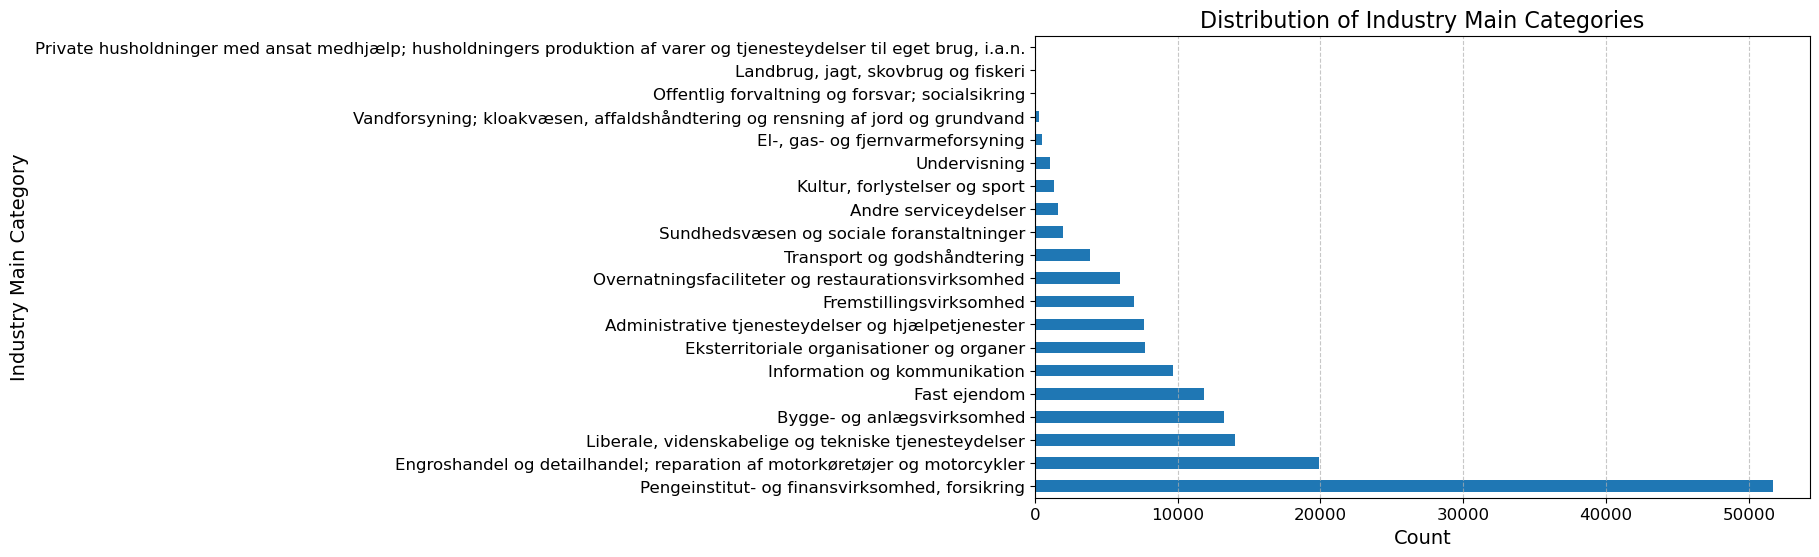

In [16]:
# Count the occurrences of each category in 'industry_mainCategory'
category_counts = cvr_df['industry_mainCategory'].value_counts()

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='barh')
plt.title("Distribution of Industry Main Categories", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Industry Main Category", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


# 0.3 Censored Data the Dataset
- Censored Companies: Active companies (is_terminated = False) are right-censored since their termination time is unknown.
- Observed Companies: Terminated companies (is_terminated = True) have known survival times.


In [17]:
cvr_df['is_terminated'] = (cvr_df['termination__date'] < '2200-01-01').astype(int)

In [18]:
is_terminated_stats = cvr_df['is_terminated'].value_counts().reset_index()
is_terminated_stats.columns = ['Termination Status', 'Count']
is_terminated_stats['Percentage'] = (is_terminated_stats['Count'] / cvr_df.shape[0]) * 100
is_terminated_stats

,Termination Status,Count,Percentage
0,1,109430,68.638274
1,0,50000,31.361726


In [19]:
# Check proportion of observations by company type
company_type_summary = cvr_df.groupby('company_type').agg(
    Total_Observations=('company_type', 'size'),  # Count the total observations
    Terminated=('is_terminated', 'sum')  # Summing 'is_terminated' counts the number of terminations
).reset_index()

# Calculate the proportion of terminations
company_type_summary['Proportion_Terminated'] = (
    company_type_summary['Terminated'] / company_type_summary['Total_Observations']
)

# Display the summary
print(company_type_summary)

# Check proportion of observations by industry type
industry_type_summary = cvr_df.groupby('industry_mainCategory').agg(
    Total_Observations=('industry_mainCategory', 'size'),
    Terminated=('is_terminated', 'sum')
).reset_index()

# Calculate the proportion of terminations
industry_type_summary['Proportion_Terminated'] = (
    industry_type_summary['Terminated'] / industry_type_summary['Total_Observations']
)

industry_type_summary

     company_type  Total_Observations  Terminated  Proportion_Terminated
0    Aktieselskab               10015        6829               0.681877
1  Anpartsselskab              149415      102601               0.686685


,industry_mainCategory,Total_Observations,Terminated,Proportion_Terminated
0,Administrative tjenesteydelser og hjælpetjenester,7675,5673,0.739153
1,Andre serviceydelser,1659,1155,0.696203
2,Bygge- og anlægsvirksomhed,13280,9623,0.724623
3,Eksterritoriale organisationer og organer,7736,7735,0.999871
4,"El-, gas- og fjernvarmeforsyning",473,268,0.566596
5,Engroshandel og detailhandel; reparation af mo...,19925,15325,0.769134
6,Fast ejendom,11863,6815,0.574475
7,Fremstillingsvirksomhed,6932,4886,0.704847
8,Information og kommunikation,9700,6993,0.720928
9,"Kultur, forlystelser og sport",1355,946,0.698155


In [55]:
industry_type_summary['industry_mainCategory'].unique

<bound method Series.unique of 0     Administrative tjenesteydelser og hjælpetjenester
1                                  Andre serviceydelser
2                            Bygge- og anlægsvirksomhed
3             Eksterritoriale organisationer og organer
4                      El-, gas- og fjernvarmeforsyning
5     Engroshandel og detailhandel; reparation af mo...
6                                          Fast ejendom
7                               Fremstillingsvirksomhed
8                          Information og kommunikation
9                         Kultur, forlystelser og sport
10                  Landbrug, jagt, skovbrug og fiskeri
11    Liberale, videnskabelige og tekniske tjenestey...
12      Offentlig forvaltning og forsvar; socialsikring
13    Overnatningsfaciliteter og restaurationsvirkso...
14       Pengeinstitut- og finansvirksomhed, forsikring
15    Private husholdninger med ansat medhjælp; hush...
16            Sundhedsvæsen og sociale foranstaltninger
17               

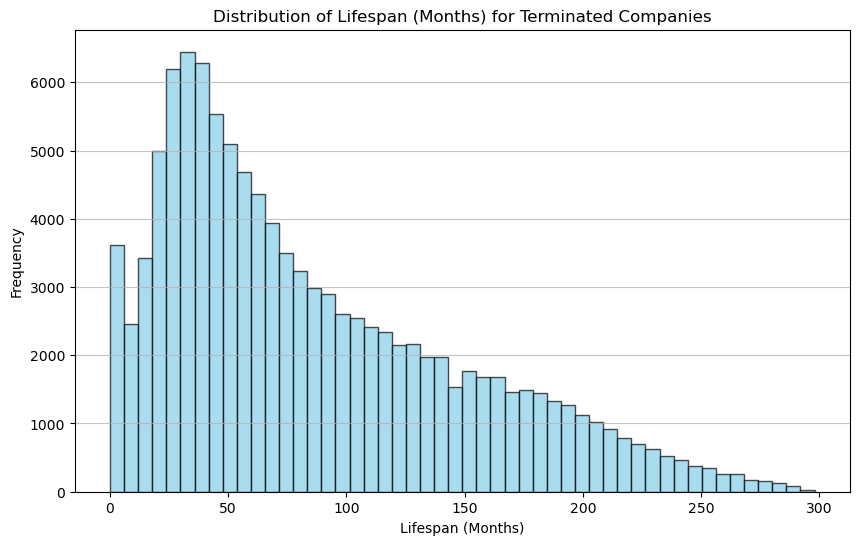

In [20]:
import matplotlib.pyplot as plt

# Filter the dataset for terminated companies
terminated_companies = cvr_df[cvr_df['is_terminated'] == True]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(terminated_companies['lifespan_months'].dropna(), bins=50, edgecolor='k', alpha=0.7, color='skyblue')
plt.title("Distribution of Lifespan (Months) for Terminated Companies")
plt.xlabel("Lifespan (Months)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [21]:
data = cvr_df.copy()

# Check for the `company_status` column
if 'company_status' not in data.columns:
    raise ValueError("The 'company_status' column is missing from the dataset. Please ensure the dataset is correct.")

# Define categories for 'forced' and 'not forced'
forced_keywords = ['Tvangsopløst', 'Opløst efter konkurs']

# Create a new column 'dissolution_type'
def categorize_dissolution(status):
    for keyword in forced_keywords:
        if keyword.lower() in str(status).lower():
            return 'Forced'
    return 'Not Forced'

data['dissolution_type'] = data['company_status'].apply(categorize_dissolution)

# Count occurrences of each category
counts = data['dissolution_type'].value_counts()

# Display the counts
print("Counts of Forced and Not Forced Dissolution:")
print(counts)

# Save the results to a CSV file (optional)
counts.to_csv('dissolution_counts.csv', index=True, header=['Count'])

# Debugging: Check sample data
print("Sample Data with Dissolution Type:")
print(data[['company_status', 'dissolution_type']].head())


Counts of Forced and Not Forced Dissolution:
dissolution_type
Not Forced    117809
Forced         41621
Name: count, dtype: int64
Sample Data with Dissolution Type:
           company_status dissolution_type
0  OPLØST EFTER SPALTNING       Not Forced
1    OPLØST EFTER KONKURS           Forced
2    OPLØST EFTER KONKURS           Forced
3            TVANGSOPLØST           Forced
4    OPLØST EFTER KONKURS           Forced


# 1. Analyze Company Survival Trends with Kaplan-Meier

**Goal:** Visualize survival probabilities over time for different company attributes, such as industry or company type.

**Method:**
- Use incorporation_date, termination_date, and company_status to compute survival time and censoring.
- Group companies by categorical variables like industry_code and company_type.
- Plot Kaplan–Meier survival curves.



## 1.1 Yearly by company type

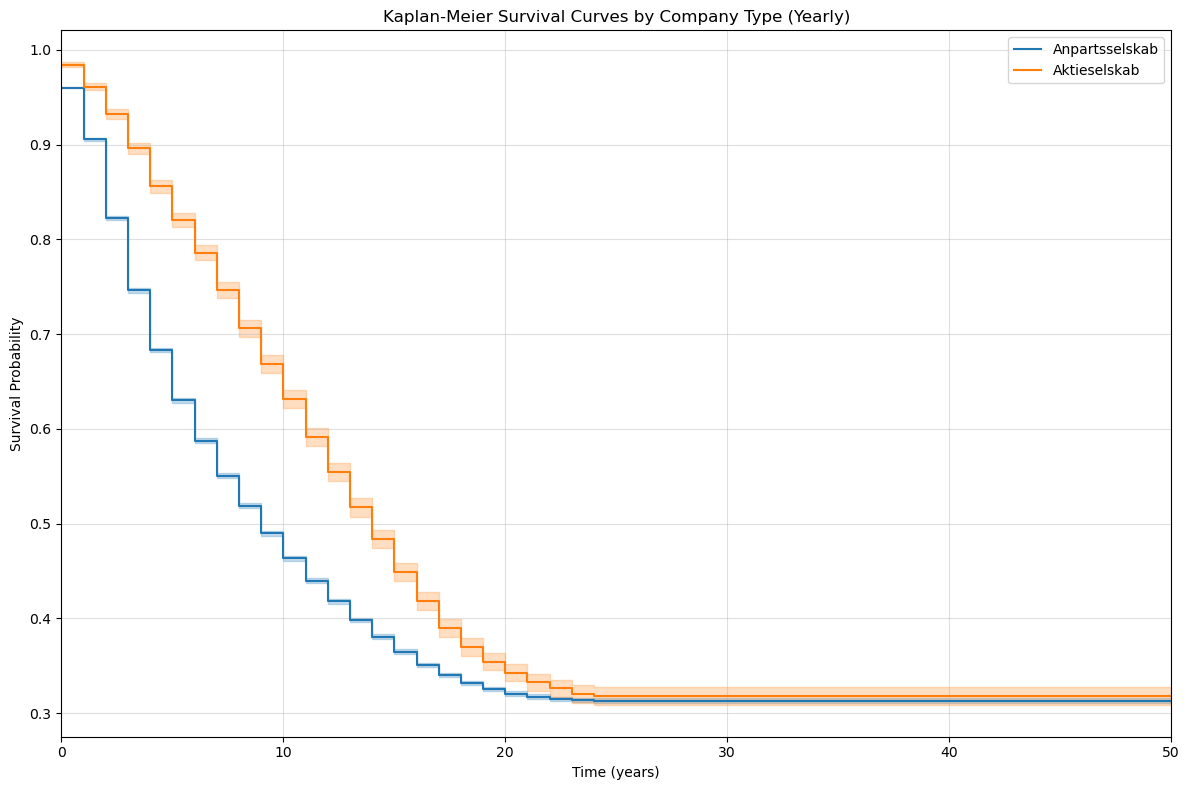

In [22]:
# Ensure lifespan_months is numeric
cvr_df['lifespan_months'] = pd.to_numeric(cvr_df['lifespan_months'], errors='coerce')

# Convert lifespan from months to years
cvr_df['lifespan_years'] = np.floor(cvr_df['lifespan_months'] / 12)

# Drop rows with missing values in relevant columns
cvr_df = cvr_df.dropna(subset=['lifespan_years', 'is_terminated', 'company_type'])

# Map 'is_terminated' to integers (1 for True, 0 for False) for Kaplan-Meier fitting
cvr_df['event'] = cvr_df['is_terminated'].astype(int)

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Group by company type and calculate Kaplan-Meier survival curves
plt.figure(figsize=(12, 8))

for company_type in cvr_df['company_type'].unique():
    subset = cvr_df[cvr_df['company_type'] == company_type]
    
    # Fit Kaplan-Meier curve
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=company_type)
    kmf.plot_survival_function()
    
# Add labels, title, and legend
plt.title("Kaplan-Meier Survival Curves by Company Type (Yearly)")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
#plt.legend(title="Company Type", bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2, fontsize='small')
# Limit X-axis
plt.xlim(0, 50)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


| Danish Description | English Translation           | Hungarian Translation          |
|--------------------|-------------------------------|---------------------------------
| Anpartsselskab     | Private limited company       | Korlátolt felelősségű társaság |
| Aktieselskab       | Public limited company        | Részvénytársaság                |

## 1.2 Yearly by industry types

In [23]:
# Step 1: Ensure lifespan_months is numeric
cvr_df['lifespan_months'] = pd.to_numeric(cvr_df['lifespan_months'], errors='coerce')

# Step 2: Calculate lifespan in years
cvr_df['lifespan_years'] = (cvr_df['lifespan_months'] / 12).apply(lambda x: round(x, 1))  # Rounded to one decimal place

# Step 3: Drop rows with missing values in relevant columns
cvr_df = cvr_df.dropna(subset=['lifespan_years', 'is_terminated', 'industry_mainCategory'])

# Step 4: Map 'is_terminated' to integers (1 for True, 0 for False) for Kaplan-Meier fitting
cvr_df['event'] = cvr_df['is_terminated'].astype(int)

# Debugging: Check the processed data
#print(cvr_df[['lifespan_years', 'is_terminated', 'event', 'industry_mainCategory']].head())


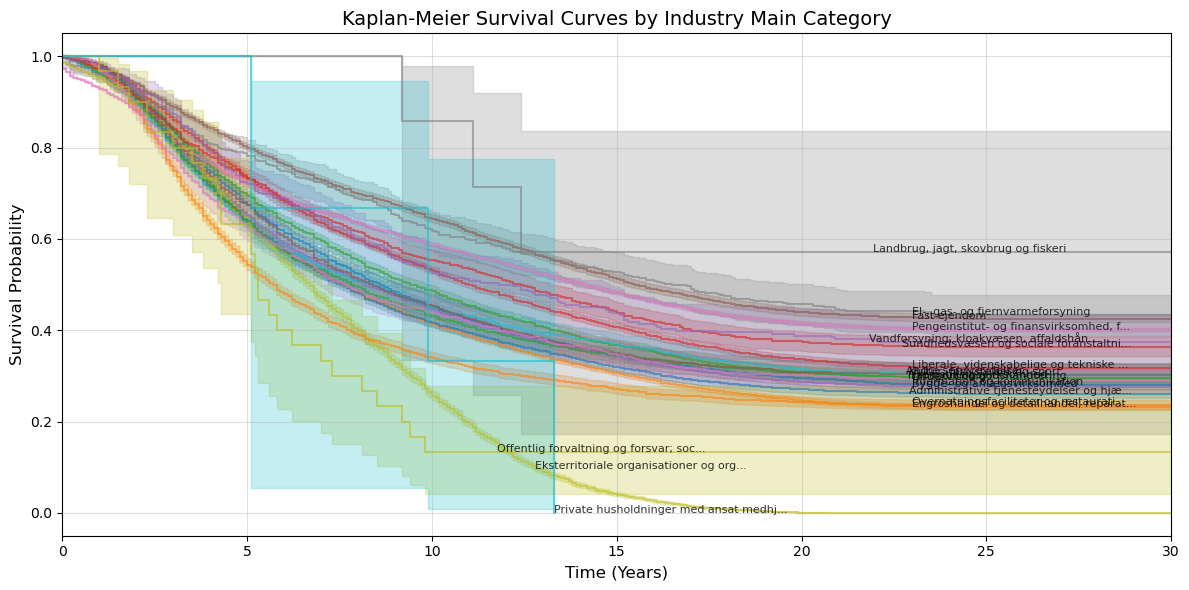

In [24]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Create a figure for the plots
plt.figure(figsize=(12, 6))

# Iterate through each industry category
for category in cvr_df['industry_mainCategory'].unique():
    subset = cvr_df[cvr_df['industry_mainCategory'] == category]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=category)
    
    # Plot the survival function
    ax = kmf.plot_survival_function(ci_show=True, alpha=0.6)
    
    # Annotate the curve directly with the industry name
    # Check if the survival curve ever reaches 0.6
    survival_data = kmf.survival_function_
    try:
        annotation_point = survival_data[survival_data.iloc[:, 0] <= 0.1].iloc[0]
        time = annotation_point.name
        value = annotation_point.values[0]
    except IndexError:
        # If survival never goes below 0.6, use the last point for annotation and move it left
        time = survival_data.index[-1] * 0.9  # Adjust position to the left
        value = survival_data.iloc[-1, 0]

    # Adjust annotation position for companies with long survival
    manual_x_offset = -157 if time > 45 else 0 # Move to the left for companies near the right edge
    
    plt.text(
        x=time + manual_x_offset,  # Adjusted time point
        y=value,  # Corresponding survival probability
        s=category[:37] + ('...' if len(category) > 37 else ''),  # Truncate long names
        fontsize=8,
        alpha=0.8,
        ha='left' if manual_x_offset else 'left'  # Adjust alignment based on position
    )

# Limit X-axis to a meaningful range (e.g., 50 years)
plt.xlim(0, 30)

# Customize Plot
plt.title("Kaplan-Meier Survival Curves by Industry Main Category", fontsize=14)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, alpha=0.4)

# Remove the legend
plt.gca().legend_.remove()

# Adjust layout for better spacing
plt.tight_layout()

# Show Plot
plt.show()


his Kaplan-Meier plot reveals:

Distinct Extremes: Industries like "Private households" and "Agriculture, forestry, and fishing" show extreme survival behaviors—quick termination or long-lasting survival.
Cluster Overlap: Many industries have overlapping survival patterns, creating a central cluster.
Confidence Intervals: Wide confidence intervals for some industries suggest variability and fewer observations.
Key Insight:
The plot effectively highlights outliers while showing that most industries have similar survival trends.

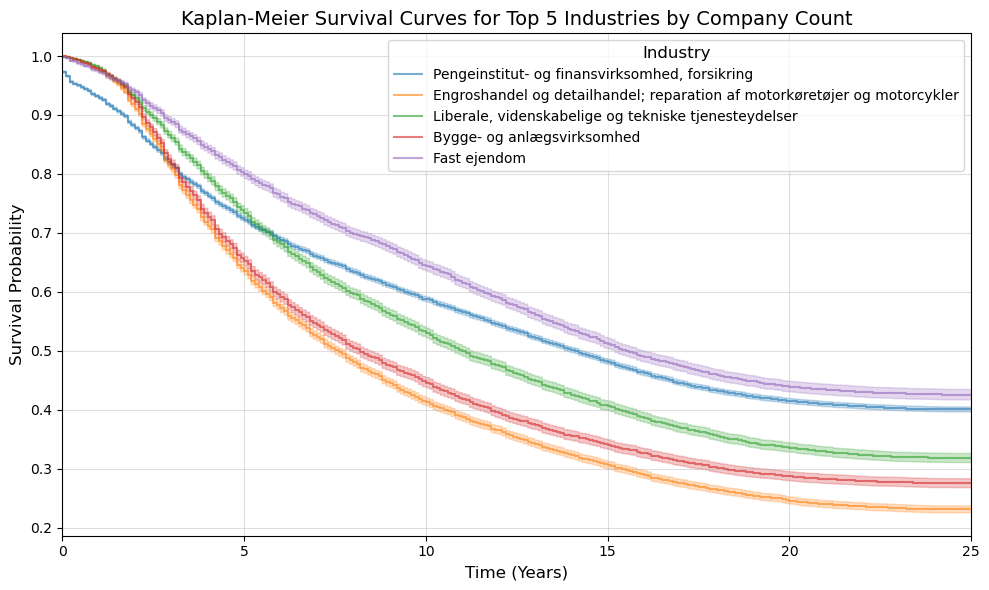

In [25]:
# Step 1: Get the top 3 industries with the highest number of companies
top_3_industries = cvr_df['industry_mainCategory'].value_counts().head(5).index

# Step 2: Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Step 3: Create a plot
plt.figure(figsize=(10, 6))

# Step 4: Iterate through the top 3 industries and plot Kaplan-Meier curves
for category in top_3_industries:
    subset = cvr_df[cvr_df['industry_mainCategory'] == category]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=category)
    
    # Plot the survival function
    kmf.plot_survival_function(ci_show=True, alpha=0.6)

# Limit X-axis to a meaningful range (e.g., 50 years)
plt.xlim(0, 25)

# Customize the plot
plt.title("Kaplan-Meier Survival Curves for Top 5 Industries by Company Count", fontsize=14)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, alpha=0.4)
plt.legend(title="Industry", fontsize=10, title_fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig("K-MCurvesTop3byCompanyCount.jpg", bbox_inches='tight')

plt.show()

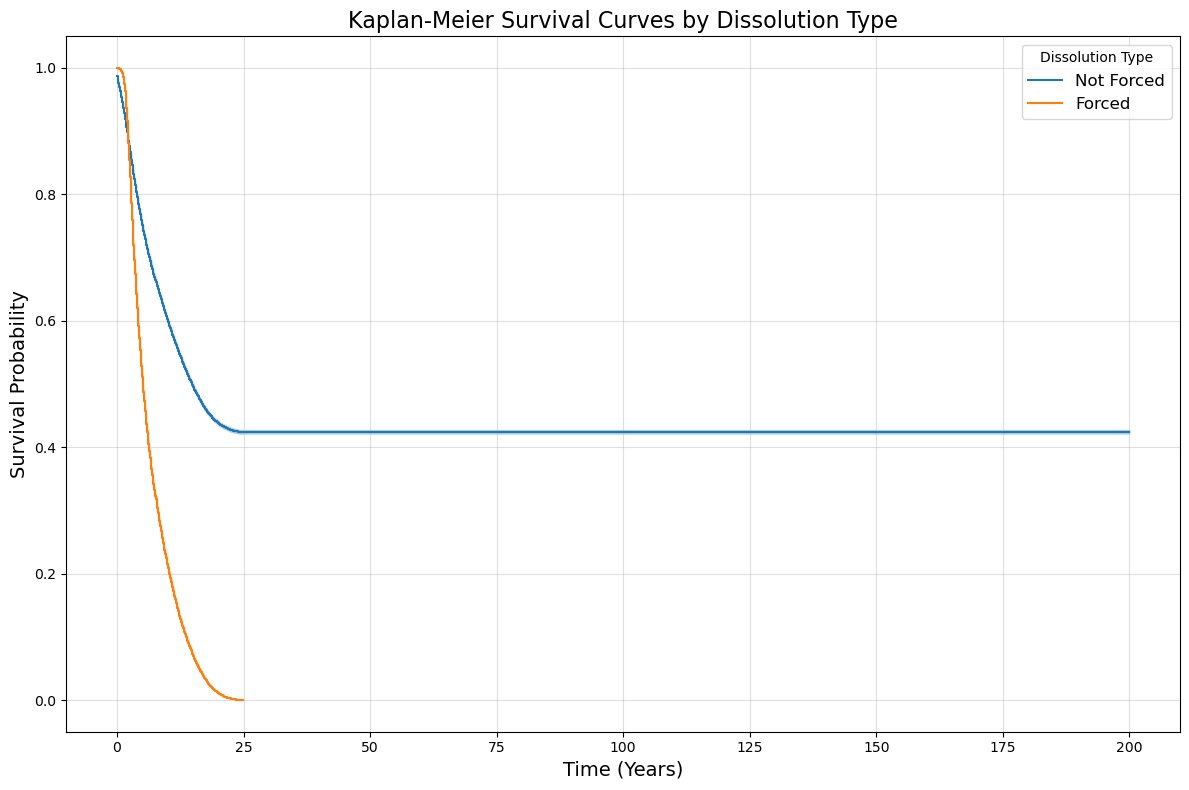

In [26]:
# Step 1: Add a 'dissolution_type' column based on company_status
def categorize_dissolution(status):
    for keyword in ['Tvangsopløst', 'Opløst efter konkurs']:
        if keyword.lower() in str(status).lower():
            return 'Forced'
    return 'Not Forced'

# Apply categorization to cvr_df
cvr_df['dissolution_type'] = cvr_df['company_status'].apply(categorize_dissolution)

# Step 2: Plot Kaplan-Meier survival curves by dissolution type
plt.figure(figsize=(12, 8))

for dissolution_type in cvr_df['dissolution_type'].unique():
    subset = cvr_df[cvr_df['dissolution_type'] == dissolution_type]
    
    # Ensure durations and events are prepared
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=dissolution_type)
    kmf.plot_survival_function(ci_show=True)

# Customize the plot
plt.title("Kaplan-Meier Survival Curves by Dissolution Type", fontsize=16)
plt.xlabel("Time (Years)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(title="Dissolution Type", fontsize=12)
plt.grid(True, alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()


In [27]:
import pandas as pd

# Filter for early-term survival periods (e.g., companies terminated in ≤ 3 years)
early_termination_threshold = 20

# Step 1: Filter early terminations
cvr_df['early_termination'] = ((cvr_df['lifespan_months'] / 12) <= early_termination_threshold) & (cvr_df['event'] == 1)

# Step 2: Group by industry and calculate rates
early_termination_rates = cvr_df.groupby('industry_mainCategory').agg(
    total_companies=('event', 'size'),  # Total companies per industry
    early_terminations=('early_termination', 'sum')  # Count of early terminations
)

# Step 3: Calculate the rate
early_termination_rates['early_termination_rate'] = early_termination_rates['early_terminations'] / early_termination_rates['total_companies']

# Step 4: Display results
print(early_termination_rates[['early_terminations', 'total_companies', 'early_termination_rate']])


                                                    early_terminations  \
industry_mainCategory                                                    
Administrative tjenesteydelser og hjælpetjenester                 5598   
Andre serviceydelser                                              1138   
Bygge- og anlægsvirksomhed                                        9468   
Eksterritoriale organisationer og organer                         7731   
El-, gas- og fjernvarmeforsyning                                   257   
Engroshandel og detailhandel; reparation af mot...               15024   
Fast ejendom                                                      6653   
Fremstillingsvirksomhed                                           4796   
Information og kommunikation                                      6836   
Kultur, forlystelser og sport                                      937   
Landbrug, jagt, skovbrug og fiskeri                                  3   
Liberale, videnskabelige og tekniske t

In [28]:
cvr_df['early_termination'] = (cvr_df['lifespan_months'] / 12 <= early_termination_threshold) & (cvr_df['event'] == 1)
cvr_df['early_termination'] 

0          True
1         False
2          True
3          True
4          True
          ...  
159425    False
159426    False
159427    False
159428    False
159429    False
Name: early_termination, Length: 159430, dtype: bool

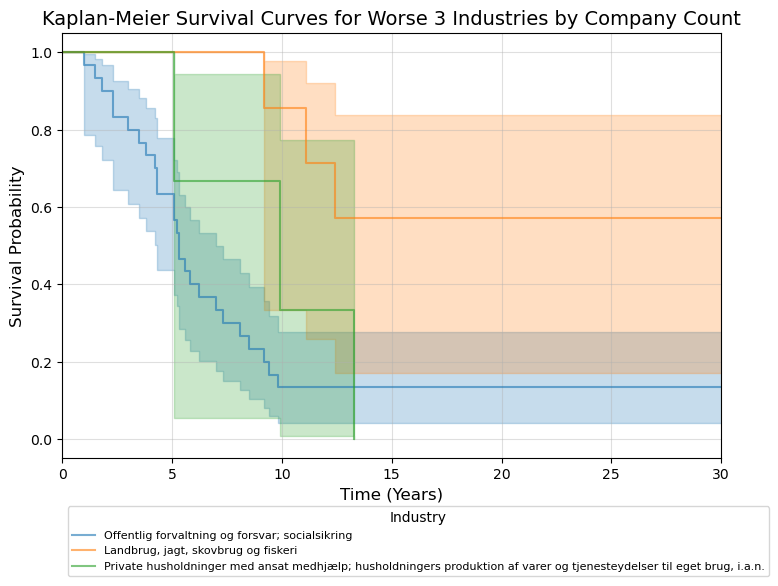

In [29]:
# Step 1: Get the top 3 industries with the highest number of companies
top_3_industries = cvr_df['industry_mainCategory'].value_counts().tail(3).index

# Step 2: Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Step 3: Create a plot
plt.figure(figsize=(10, 6))

# Step 4: Iterate through the top 3 industries and plot Kaplan-Meier curves
for category in top_3_industries:
    subset = cvr_df[cvr_df['industry_mainCategory'] == category]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=category)
    
    # Plot the survival function
    kmf.plot_survival_function(ci_show=True, alpha=0.6)

# Limit X-axis to a meaningful range (e.g., 30 years)
plt.xlim(0, 30)

# Customize the plot
plt.title("Kaplan-Meier Survival Curves for Worse 3 Industries by Company Count", fontsize=14)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, alpha=0.4)

# Move the legend outside of the plot
plt.legend(
    title="Industry", fontsize=8, title_fontsize=10,
    loc='upper left', bbox_to_anchor=(0, -0.1)  # Position legend outside the plot
)

# Adjust layout to accommodate the legend
plt.tight_layout(rect=[0, 0, 0.75, 1])  # Leave space for the legend

# Show the plot
plt.show()


In [30]:
# Filter dataset for companies with industry code 110500
beer_companies = cvr_df[cvr_df['industry_code'] == '110500 - Fremstilling af øl']

# Step 1: Ensure lifespan_months is numeric
beer_companies['lifespan_months'] = pd.to_numeric(beer_companies['lifespan_months'], errors='coerce')

# Step 2: Calculate lifespan in years
beer_companies['lifespan_years'] = (beer_companies['lifespan_months'] / 12).apply(lambda x: round(x, 1))  # Rounded to one decimal place

# Step 3: Drop rows with missing values in relevant columns
beer_companies = beer_companies.dropna(subset=['lifespan_years', 'is_terminated', 'industry_mainCategory'])

# Step 4: Map 'is_terminated' to integers (1 for True, 0 for False) for Kaplan-Meier fitting
beer_companies['event'] = beer_companies['is_terminated'].astype(int)




# Debugging: Check if Carlsberg or similar data is included
print(f"Number of companies in industry code 110500: {len(beer_companies)}")
#print(beer_companies[['cvr_number', 'company_type', 'lifespan_years', 'is_terminated']].head())



Number of companies in industry code 110500: 66


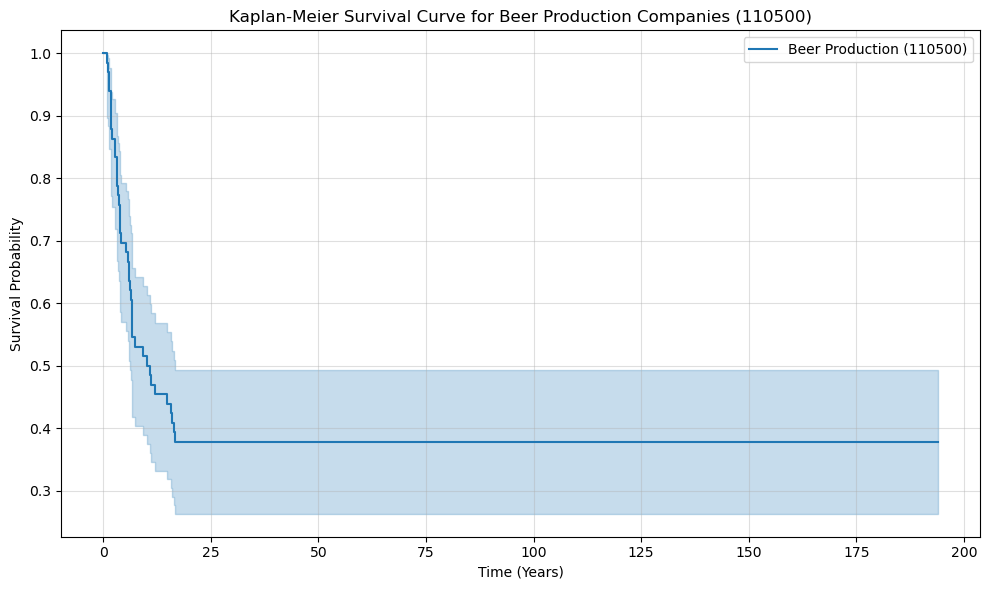

In [31]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit Kaplan-Meier survival model
kmf.fit(durations=beer_companies['lifespan_years'], event_observed=beer_companies['event'], label='Beer Production (110500)')

# Plot survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan-Meier Survival Curve for Beer Production Companies (110500)")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(True, alpha=0.4)
# Show Plot
plt.show()


# **2. Identify Key Factors Influencing the Risk of Termination with Cox Proportional Hazards Model**


### **Cox Proportional Hazards Model**

#### **Goal:**
Assess and quantify the impact of covariates on the risk of company termination.


#### **Method:**
- Fit the Cox proportional hazards model to estimate the **Hazard Ratios (HRs)** for each covariate.
- Test the **proportionality assumption** of the model.



## 2.1 MODEL 1: Structural Factors
Step 1: Preprocessing and Practical Considerations
We’ll focus on structural covariates:

Structural Factors:
industry_code (or industry_mainCategory if mapped codes are preferred).
company_type.
number_of_names.
has_owners (binary: derived from number_of_owners > 0).
Practical Considerations:

Categorical Variables:

industry_mainCategory and company_type need to be encoded as categorical variables.
Use one-hot encoding or treat them directly as categorical variables in the Cox model.
Missing Values:

Check for missing or invalid data in the selected columns.
Impute or drop rows with missing values (depending on the extent of missingness).
Proportional Hazards Assumption:

After running the model, test whether the proportional hazards assumption holds for each covariate.



Breslow baseline estimation is a method used to estimate the baseline hazard function in Cox Proportional Hazards Models when tied event times occur (i.e., multiple events happening at the same time). The Cox model does not assume a specific distribution for survival times, but the baseline hazard is still required for the model's predictions. Breslow's method is a common approach to handle ties and is computationally efficient.

<lifelines.CoxPHFitter: fitted with 159430 total observations, 50000 right-censored observations>
             duration col = 'lifespan_years'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 159430
number of events observed = 109430
   partial log-likelihood = -1254905.33
         time fit was run = 2024-12-20 11:47:31 UTC

---
                                                                                                                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                
number_of_owners_centered                                                                                               -0.14      0.87      0.00           -0.14           -0.13                0.87                0.88
number_of_names_centered                                                                                                -0.03      0.97      0.00           -0.04           -0.03                0.96                0.97
I_Administrative tjenesteydelser og hjælpetjenester                                                                      0.12      1.13      0.01            0.09            0.15                1.10                1.16
I_Andre serviceydelser                                                                                                   0.03      1.03      0.03           -0.03            0.08                0.97                1.09
I_Bygge- og anlægsvirksomhed                                                                                             0.05      1.06      0.01            0.03            0.08                1.03                1.08
I_Eksterritoriale organisationer og organer                                                                              0.53      1.69      0.01            0.50            0.55                1.65                1.74
I_El-, gas- og fjernvarmeforsyning                                                                                      -0.37      0.69      0.06           -0.48           -0.27                0.62                0.77
I_Engroshandel og detailhandel; reparation af motorkøretøjer og motorcykler                                              0.17      1.19      0.01            0.15            0.19                1.16                1.21
I_Fast ejendom                                                                                                          -0.33      0.72      0.01           -0.35           -0.30                0.70                0.74
I_Fremstillingsvirksomhed                                                                                                0.00      1.00      0.01           -0.02            0.03                0.98                1.03
I_Kultur, forlystelser og sport                                                                                          0.02      1.02      0.03           -0.04            0.08                0.96                1.09
I_Landbrug, jagt, skovbrug og fiskeri                                                                                   -0.77      0.46      0.49           -1.73            0.18                0.18                1.19
I_Liberale, videnskabelige og tekniske tjenesteydelser                                                                  -0.09      0.92      0.01           -0.11           -0.06                0.90                0.94
I_Offentlig forvaltning og forsvar; socialsikring                                                                        0.45      1.57      0.19            0.08            0.83                1.08                2.28
I_Overnatningsfaciliteter og restaurationsvirksomhed              

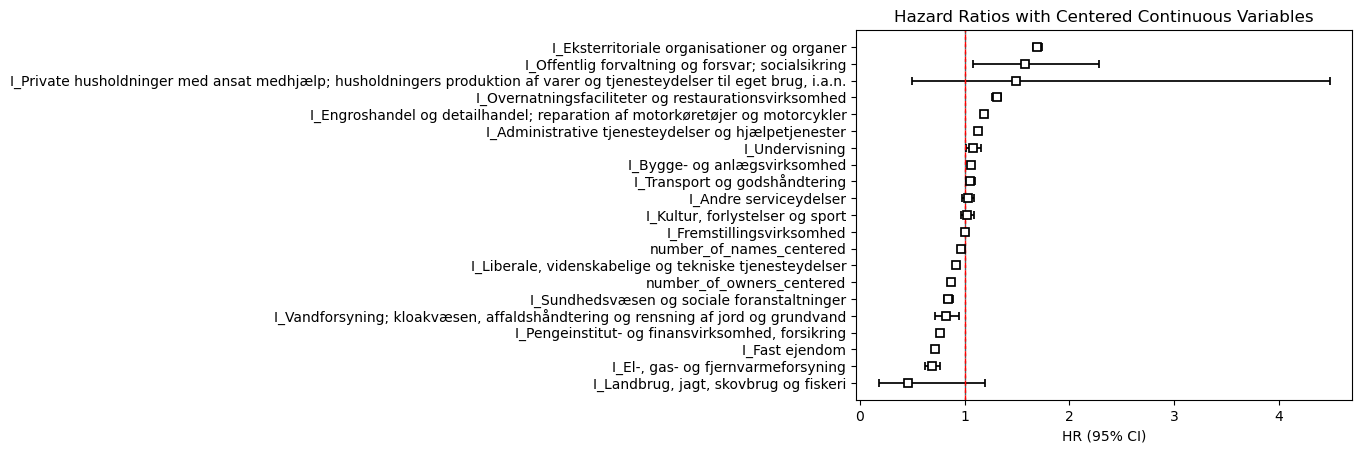

Cox Proportional Hazards Model complete. Plot saved as 'cox_model_centered.jpg'.


In [56]:
import pandas as pd
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# Step 1: Structural covariates for Model 1
structural_columns = ['industry_mainCategory', 'number_of_owners', 'number_of_names']

# Step 2: Filter the dataset for the relevant columns
model_1_df = cvr_df[structural_columns + ['lifespan_years', 'event']].copy()

# Step 3: Drop rows with missing values in the structural columns or target variables
model_1_df = model_1_df.dropna(subset=structural_columns + ['lifespan_years', 'event'])

# Step 4: Center the continuous variables
model_1_df['number_of_owners_centered'] = model_1_df['number_of_owners'] - model_1_df['number_of_owners'].mean()
model_1_df['number_of_names_centered'] = model_1_df['number_of_names'] - model_1_df['number_of_names'].mean()

# Step 5: Set 'Liberale, videnskabelige og tekniske tjenesteydelser' as the baseline
baseline_category = "Information og kommunikation"

# One-hot encode 'industry_mainCategory' and drop the baseline category
industry_dummies = pd.get_dummies(model_1_df['industry_mainCategory'], prefix='I', drop_first=False)
if f"I_{baseline_category}" in industry_dummies.columns:
    industry_dummies = industry_dummies.drop(columns=f"I_{baseline_category}")

# Combine dummy variables with centered continuous variables
model_1_df_encoded = pd.concat([
    model_1_df.drop(columns=['industry_mainCategory', 'number_of_owners', 'number_of_names']),
    industry_dummies
], axis=1)

# Step 6: Fit the Cox Proportional Hazards model
cox_model_1 = CoxPHFitter(penalizer=0.1)  # Add a small penalizer
cox_model_1.fit(model_1_df_encoded, duration_col='lifespan_years', event_col='event')

# Step 7: Summarize and plot the results
cox_model_1.print_summary()
ax = cox_model_1.plot(hazard_ratios=True)

# Customize the plot
plt.title("Hazard Ratios with Centered Continuous Variables")
plt.axvline(1, color='red', linestyle='--', linewidth=1)
plt.tight_layout()

# Save the plot
plt.savefig("cox_model_centered.jpg", bbox_inches='tight')
plt.show()

print("Cox Proportional Hazards Model complete. Plot saved as 'cox_model_centered.jpg'.")


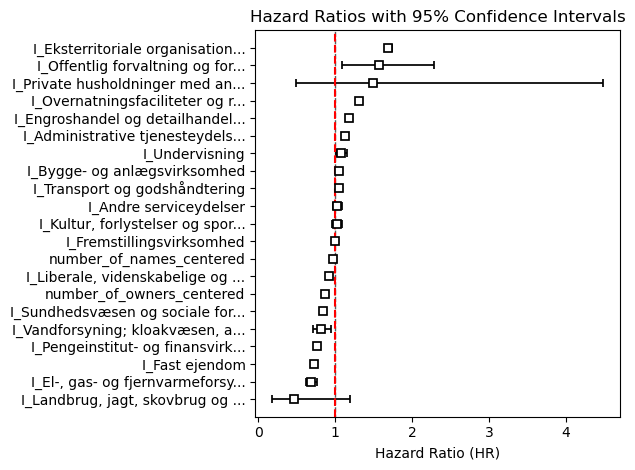

In [57]:
import matplotlib.pyplot as plt

# Fit the Cox model with a penalizer
cox_model_1 = CoxPHFitter(penalizer=0.1)
cox_model_1.fit(model_1_df_encoded, duration_col='lifespan_years', event_col='event')

# Plot the hazard ratios
ax = cox_model_1.plot(hazard_ratios=True)

# Truncate long Y-axis labels to the first 50 characters
def truncate_labels(ax, max_length=30):
    """Truncate Y-axis labels to a fixed length and add '...'."""
    truncated_labels = [
        label.get_text()[:max_length] + '...' if len(label.get_text()) > max_length else label.get_text()
        for label in ax.get_yticklabels()
    ]
    ax.set_yticklabels(truncated_labels, fontsize=10, ha='right')

truncate_labels(ax)

# Remove the grid lines
ax.grid(False)

# Add a red reference line at HR = 1
plt.axvline(1, color='red', linestyle='--')

# Customize the plot further
plt.title("Hazard Ratios with 95% Confidence Intervals", fontsize=12)
plt.xlabel("Hazard Ratio (HR)", fontsize=10)
plt.tight_layout()

# Save and display the plot
plt.savefig("HR_model1.jpg", bbox_inches='tight')
plt.show()


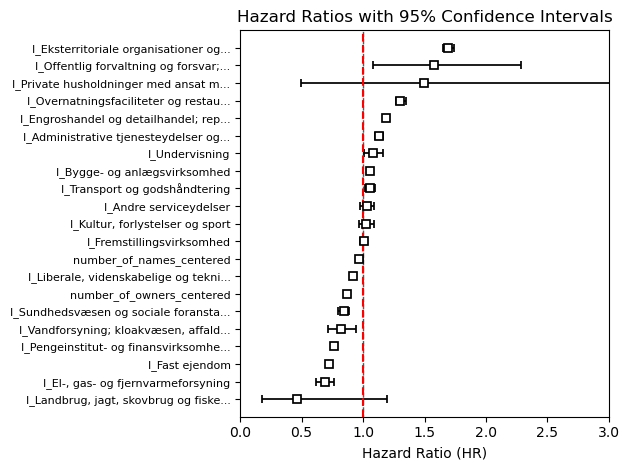

In [58]:
import matplotlib.pyplot as plt

# Fit the Cox model with a penalizer
cox_model_1 = CoxPHFitter(penalizer=0.1)
cox_model_1.fit(model_1_df_encoded, duration_col='lifespan_years', event_col='event')

# Plot the hazard ratios
ax = cox_model_1.plot(hazard_ratios=True)

# Truncate long labels
def truncate_labels(ax, max_length=35):
    """Truncate Y-axis labels."""
    truncated_labels = [
        label.get_text()[:max_length] + '...' if len(label.get_text()) > max_length else label.get_text()
        for label in ax.get_yticklabels()
    ]
    ax.set_yticklabels(truncated_labels, fontsize=8, ha='right')

truncate_labels(ax)

# Set X-axis limits to improve visibility
plt.xlim(0, 3)  # Adjust the range as needed (exclude extreme values)

# Annotate outliers
outlier_x = 4.0  # Example: Known extreme value
outlier_y = 18    # The index of the problematic CI (manually checked)
plt.annotate("Outlier", xy=(outlier_x, outlier_y), xytext=(1.5, outlier_y + 1),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=10, color='red')

# Add a red reference line at HR = 1
plt.axvline(1, color='red', linestyle='--')

# Remove grid
ax.grid(False)

# Customize the plot
plt.title("Hazard Ratios with 95% Confidence Intervals", fontsize=12)
plt.xlabel("Hazard Ratio (HR)", fontsize=10)
plt.tight_layout()

# Save and show
plt.savefig("hazard_ratios_cleaned.jpg", bbox_inches='tight')
plt.show()


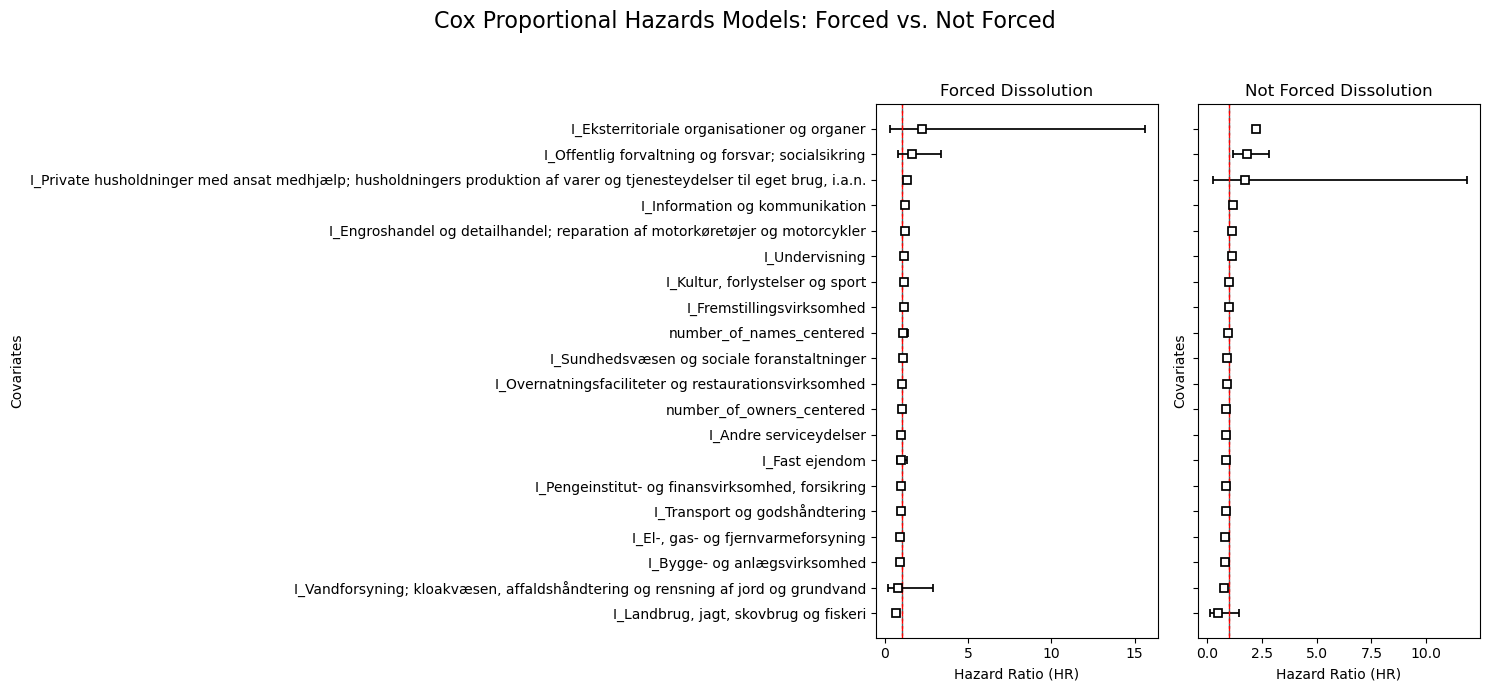

In [35]:
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Filter the dataset by dissolution type
forced_df = cvr_df[cvr_df['dissolution_type'] == 'Forced']
not_forced_df = cvr_df[cvr_df['dissolution_type'] == 'Not Forced']

# Function to fit and plot Cox models for each dataset
def plot_cox_model(data, title, ax):
    # Structural covariates for Model 1
    structural_columns = ['industry_mainCategory', 'number_of_owners', 'number_of_names']
    model_df = data[structural_columns + ['lifespan_years', 'event']].dropna()

    # Center continuous variables
    model_df['number_of_owners_centered'] = model_df['number_of_owners'] - model_df['number_of_owners'].mean()
    model_df['number_of_names_centered'] = model_df['number_of_names'] - model_df['number_of_names'].mean()

    # One-hot encode categorical variables
    baseline_category = "Liberale, videnskabelige og tekniske tjenesteydelser"
    industry_dummies = pd.get_dummies(model_df['industry_mainCategory'], prefix='I', drop_first=True)
    if f"I_{baseline_category}" in industry_dummies.columns:
        industry_dummies = industry_dummies.drop(columns=f"I_{baseline_category}")

    # Combine with encoded data
    model_df_encoded = pd.concat([
        model_df.drop(columns=['industry_mainCategory', 'number_of_owners', 'number_of_names']),
        industry_dummies
    ], axis=1)

    # Fit the Cox Proportional Hazards model
    cox_model = CoxPHFitter(penalizer=0.1)
    cox_model.fit(model_df_encoded, duration_col='lifespan_years', event_col='event')
    cox_model.plot(hazard_ratios=True, ax=ax)
    
    # Customize plot
    ax.set_title(title)
    ax.axvline(1, color='red', linestyle='--', linewidth=1)
    ax.grid(False)
    ax.set_xlabel("Hazard Ratio (HR)")
    ax.set_ylabel("Covariates")
    return cox_model

# Plot side-by-side Cox models
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
plot_cox_model(forced_df, "Forced Dissolution", axes[0])
plot_cox_model(not_forced_df, "Not Forced Dissolution", axes[1])

# Final plot adjustments
fig.suptitle("Cox Proportional Hazards Models: Forced vs. Not Forced", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 2.2 MODEL 2: Financial Metrics
Step 1: Preprocessing and Practical Considerations
We'll now focus on financial covariates:

Financial Factors:
Financial Metrics:

mean_equity
mean_result
mean_staff_expenses
std_equity
std_result
Practical Considerations:

Handling Missing Values:
Many financial metrics have missing or zero values due to unreported or unavailable financial statements.
Convert missing values to binary indicators (has_financial_data) and include it as a covariate, or impute missing values carefully.
Zero Values:
Replace zeros with small positive values (if applicable) or group such companies as "no financial activity."
Skewed Distributions:
Log-transform highly skewed financial metrics to improve interpretability and model stability.
Proportional Hazards Assumption:
After running the model, test whether the proportional hazards assumption holds for financial covariates.
Visualize Schoenfeld residuals for key covariates to assess their behavior over time.

In [37]:
# Define the financial metrics
financial_columns = [
    'mean_equity', 'mean_result', 'mean_staff_expenses', 
    'std_equity', 'std_result'
]

# Step 1: Create a copy of the data
model_2_df = cvr_df.copy()

# Step 2: Drop rows with missing values in financial metrics
model_2_df = model_2_df.dropna(subset=financial_columns)

# Step 3: Ensure lifespan and event columns are present
model_2_df = model_2_df[['lifespan_years', 'event'] + financial_columns]

# Debugging: Inspect remaining rows
print(f"Remaining rows after dropping missing values: {model_2_df.shape[0]}")
print(f"Number of events (terminations): {model_2_df['event'].sum()}")


Remaining rows after dropping missing values: 43206
Number of events (terminations): 30014


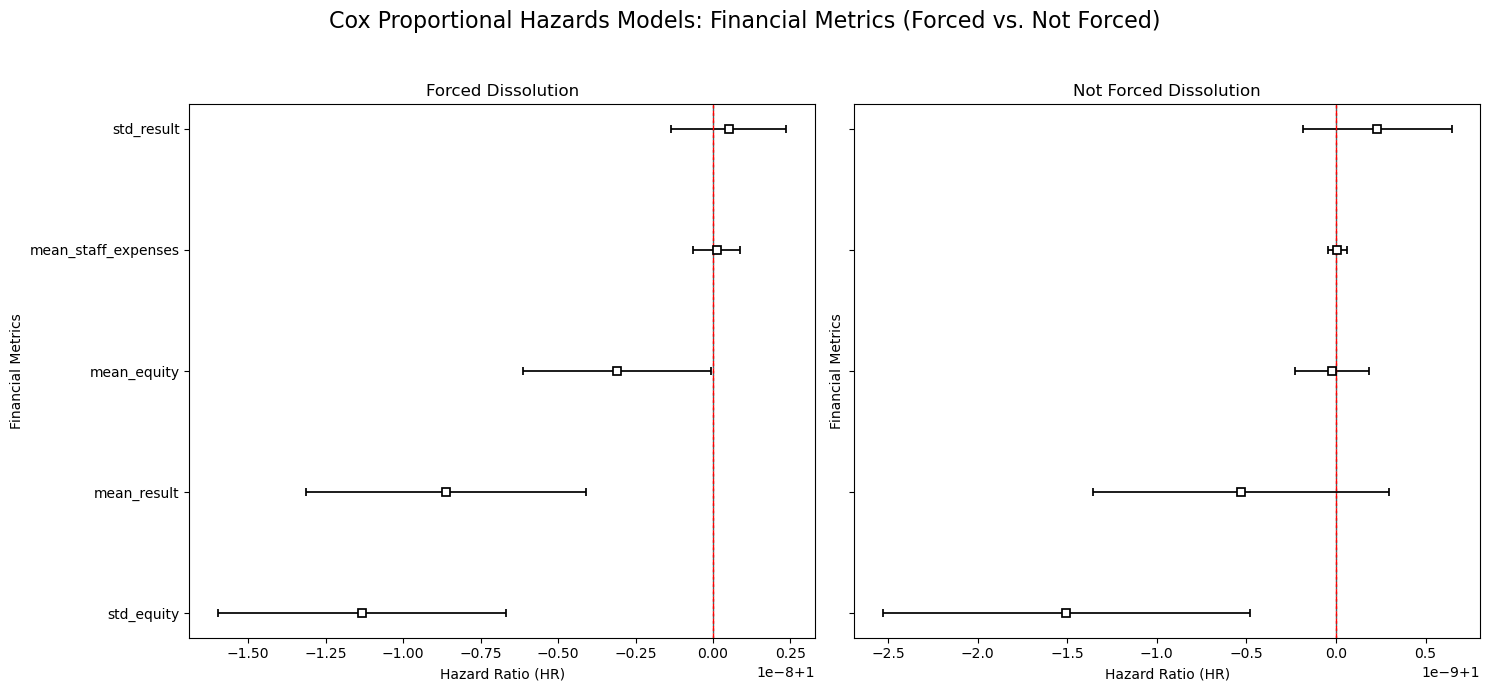

In [38]:
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Step 1: Split the dataset into "Forced" and "Not Forced"
forced_df = cvr_df[cvr_df['dissolution_type'] == 'Forced']
not_forced_df = cvr_df[cvr_df['dissolution_type'] == 'Not Forced']

# Step 2: Preprocessing function for financial metrics
def preprocess_model_2(data):
    # Define the financial metrics
    financial_columns = [
        'mean_equity', 'mean_result', 'mean_staff_expenses', 
        'std_equity', 'std_result'
    ]
    
    # Drop rows with missing values in financial metrics
    data = data.dropna(subset=financial_columns)
    
    # Select only lifespan, event, and financial metrics
    data = data[['lifespan_years', 'event'] + financial_columns]
    
    return data

# Step 3: Function to plot Cox model for financial metrics
def plot_cox_model_financial(data, title, ax):
    # Preprocess the dataset
    model_df = preprocess_model_2(data)
    
    # Fit the Cox Proportional Hazards model
    cox_model = CoxPHFitter()
    cox_model.fit(model_df, duration_col='lifespan_years', event_col='event')
    
    # Plot Hazard Ratios
    cox_model.plot(hazard_ratios=True, ax=ax)
    ax.set_title(title)
    ax.axvline(1, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel("Hazard Ratio (HR)")
    ax.set_ylabel("Financial Metrics")
    ax.grid(False)

# Step 4: Plot side-by-side Cox models
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
plot_cox_model_financial(forced_df, "Forced Dissolution", axes[0])
plot_cox_model_financial(not_forced_df, "Not Forced Dissolution", axes[1])

# Final layout adjustments
fig.suptitle("Cox Proportional Hazards Models: Financial Metrics (Forced vs. Not Forced)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


this is a sufficient number of observations and events to proceed with building a robust Cox Proportional Hazards Model for financial metrics. Here's the step-by-step approach:

<lifelines.CoxPHFitter: fitted with 43206 total observations, 13192 right-censored observations>
             duration col = 'lifespan_years'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 43206
number of events observed = 30014
   partial log-likelihood = -305955.99
         time fit was run = 2024-12-20 11:03:01 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
mean_equity         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
mean_result         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
mean_staff_expenses -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
std_equity          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
std_result          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                     cmp to     z      p  -log2(p)
covariate                                         
mean_equity            0.00 -3.95 <0.005     13.65
mean_result            0.00 -4.56 <0.005     17.59
mean_staff_expenses    0.00 -1.17   0.24      2.04
std_equity             0.00 -2.29   0.02      5.52
std_result             0.00 -0.96   0.34      1.56
---
Concordance = 0.65
Partial AIC = 611921.99
log-likelihood ratio test = 85.29 on 5 df
-log2(p) of ll-ratio test = 53.77

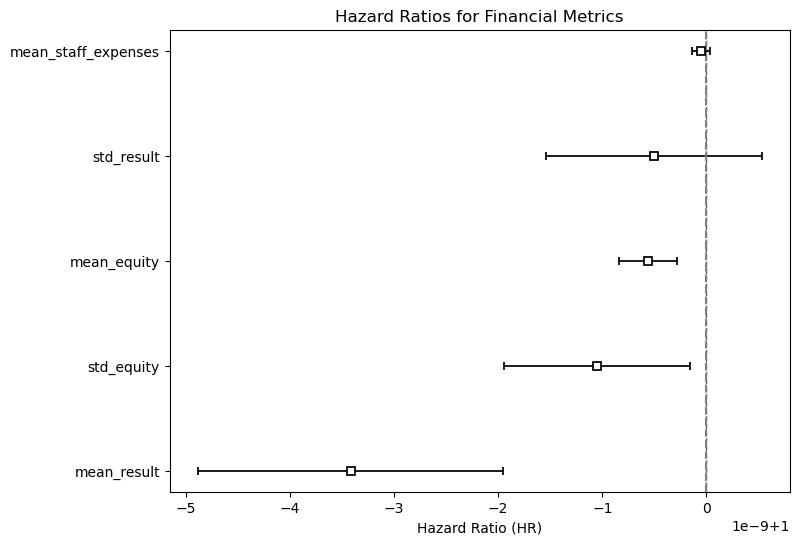

In [39]:
# Initialize the Cox Proportional Hazards model
cox_model_2 = CoxPHFitter()

# Fit the model to the data
cox_model_2.fit(model_2_df, duration_col='lifespan_years', event_col='event')

# Summary of results
cox_model_2.print_summary()

# Plot the hazard ratios (exponentiate the coefficients)
plt.figure(figsize=(8, 6))  # Adjust figure size
ax = plt.gca()

# Plot HRs with confidence intervals
cox_model_2.plot(hazard_ratios=True, ax=ax)
plt.title("Hazard Ratios for Financial Metrics")
plt.xlabel("Hazard Ratio (HR)")
plt.axvline(1, color="grey", linestyle="--")  # Reference line at HR=1

# Save the plot
plt.savefig("cox_model2.jpg", bbox_inches='tight')

# Display the plot
plt.show()


Fitting model for: mean_equity
Fitting model for: mean_result
Fitting model for: mean_staff_expenses
Fitting model for: std_equity
Fitting model for: std_result


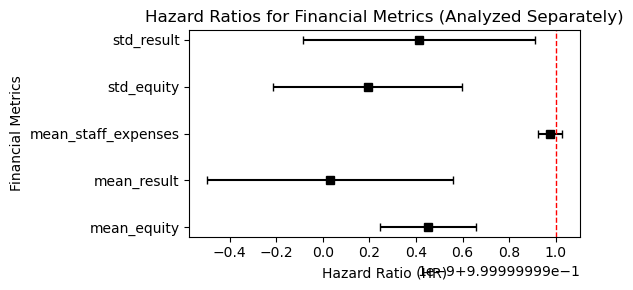

In [40]:
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import pandas as pd

# Financial metrics to analyze
financial_metrics = ['mean_equity', 'mean_result', 'mean_staff_expenses', 'std_equity', 'std_result']

# List to store the Cox model summaries
results = []

# Loop through each financial metric and fit a separate model
for metric in financial_metrics:
    print(f"Fitting model for: {metric}")
    temp_df = model_2_df[['lifespan_years', 'event', metric]].dropna()
    
    # Fit the Cox model
    cox_model_temp = CoxPHFitter(penalizer=0.1)
    cox_model_temp.fit(temp_df, duration_col='lifespan_years', event_col='event')
    
    # Add the metric name to the summary for identification
    summary_df = cox_model_temp.summary
    summary_df['Metric'] = metric  # Properly add the column for variable name
    results.append(summary_df)

# Combine all results into a single DataFrame
results_df = pd.concat(results)

# Reset index for easier plotting
results_df.reset_index(inplace=True)

# Plot Hazard Ratios with the same style as before
plt.figure(figsize=(6, 3))
plt.errorbar(
    x=results_df['exp(coef)'], 
    y=results_df['Metric'], 
    xerr=[
        results_df['exp(coef)'] - results_df['exp(coef) lower 95%'], 
        results_df['exp(coef) upper 95%'] - results_df['exp(coef)']
    ],
    fmt='s',  # Square marker
    color='black',
    capsize=3
)
# Adjust the Y-axis ticks and limits to reduce spacing
ax.set_ylim(-0.5, 1.5)  # Manually set tighter Y-axis limits
ax.set_yticks([0, 1])  # Force two specific tick positions for the two metrics

# Adjust layout to avoid whitespace
plt.tight_layout()
plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.1)

# Add a reference line at HR = 1
plt.axvline(1, color='red', linestyle='--', linewidth=1)

# Customize the plot
plt.title("Hazard Ratios for Financial Metrics (Analyzed Separately)", fontsize=12)
plt.xlabel("Hazard Ratio (HR)", fontsize=10)
plt.ylabel("Financial Metrics", fontsize=10)
plt.tight_layout()

# Save and display the plot
plt.savefig("HR_financial_metrics_same_style.jpg", bbox_inches='tight')
plt.show()


In [41]:
## Test proportional hazards assumption
#cox_model_2.check_assumptions(model_2_df, p_value_threshold=0.05)


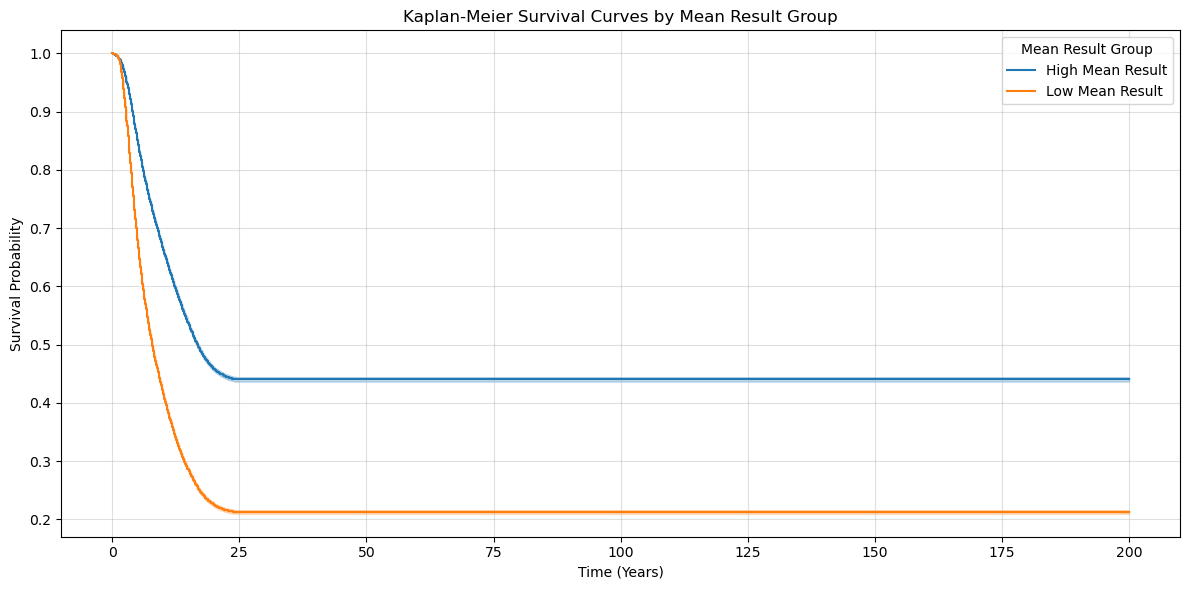

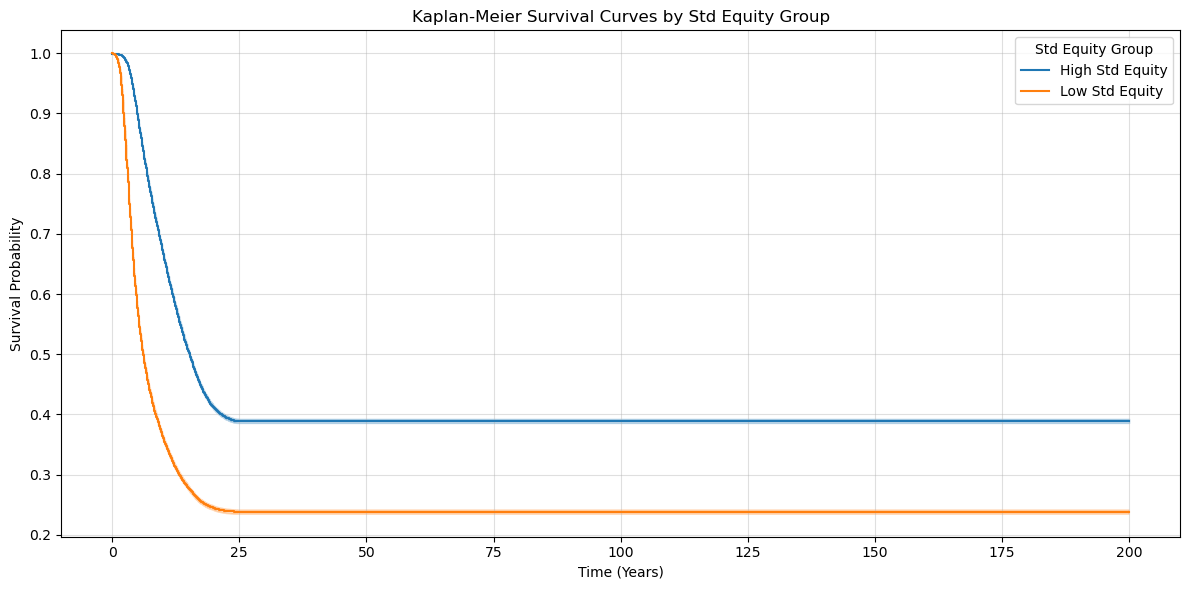

In [44]:
# Step 1: Define thresholds for high and low groups (e.g., median split)
median_mean_result = cvr_df['mean_result'].median()
median_std_equity = cvr_df['std_equity'].median()

# Step 2: Create groups for mean_result and std_equity
cvr_df['mean_result_group'] = np.where(cvr_df['mean_result'] >= median_mean_result, 'High Mean Result', 'Low Mean Result')
cvr_df['std_equity_group'] = np.where(cvr_df['std_equity'] >= median_std_equity, 'High Std Equity', 'Low Std Equity')

# Step 3: Drop rows with NaN values in relevant columns
columns_to_check = ['lifespan_years', 'event', 'mean_result', 'std_equity', 'mean_result_group', 'std_equity_group']
cvr_df_cleaned = cvr_df.dropna(subset=columns_to_check)

# Step 4: Kaplan-Meier analysis for mean_result_group
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(12, 6))
for group in cvr_df_cleaned['mean_result_group'].unique():
    subset = cvr_df_cleaned[cvr_df_cleaned['mean_result_group'] == group]
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves by Mean Result Group")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.grid(True, alpha=0.4)
plt.legend(title="Mean Result Group")
plt.tight_layout()
plt.show()

# Step 5: Kaplan-Meier analysis for std_equity_group
plt.figure(figsize=(12, 6))
for group in cvr_df_cleaned['std_equity_group'].unique():
    subset = cvr_df_cleaned[cvr_df_cleaned['std_equity_group'] == group]
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves by Std Equity Group")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.grid(True, alpha=0.4)
plt.legend(title="Std Equity Group")
plt.tight_layout()
plt.show()


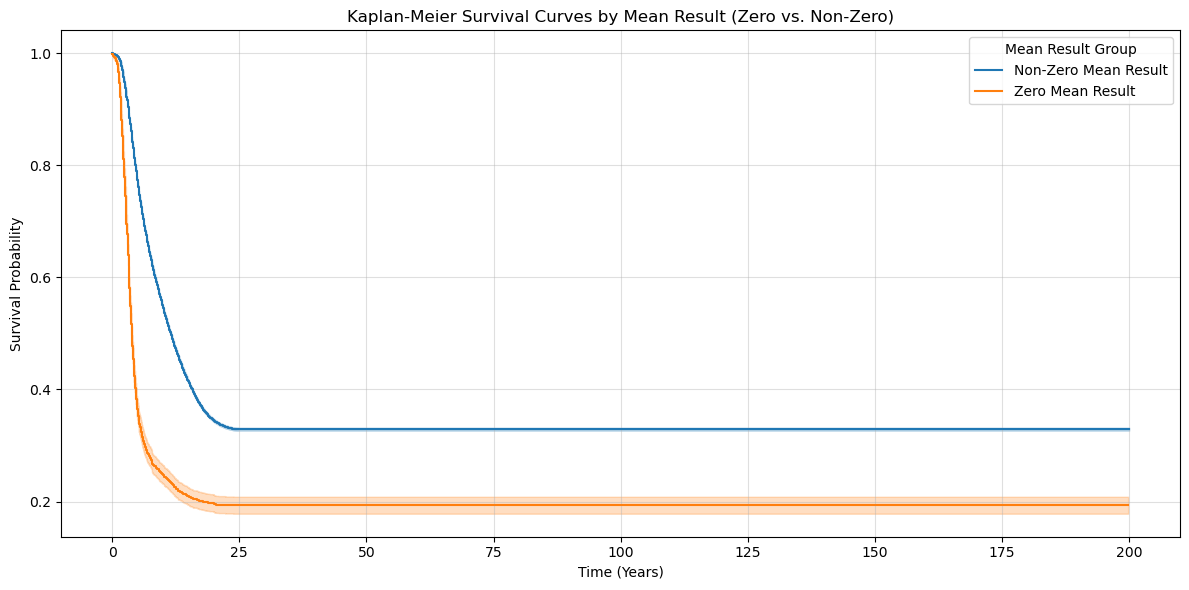

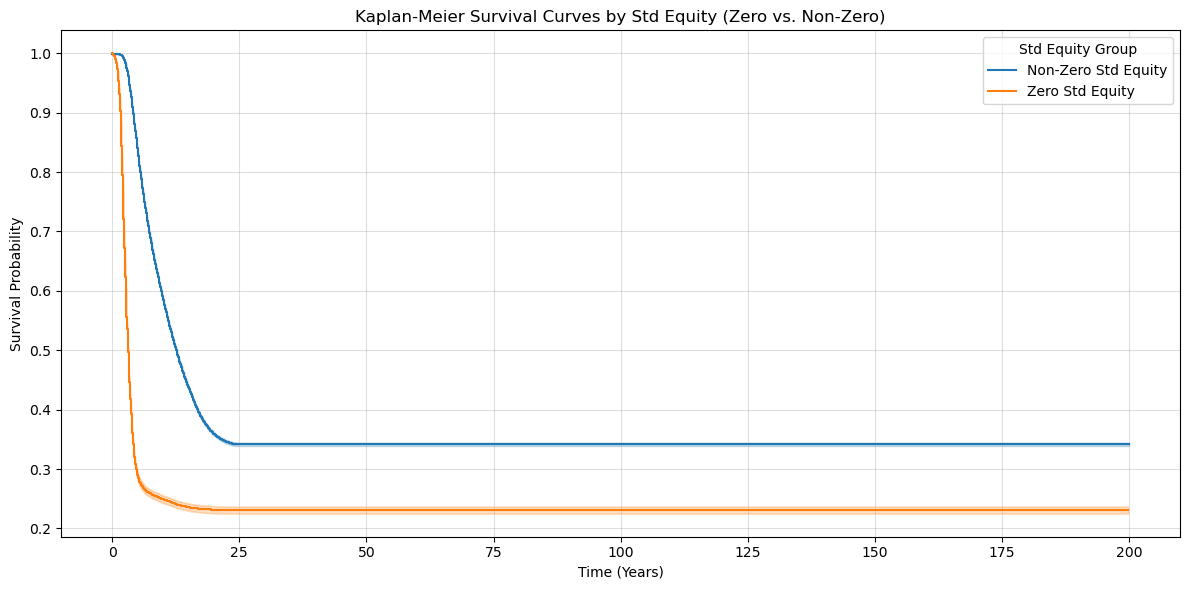

In [45]:
# Step 1: Create groups based on zero vs. non-zero values
cvr_df['mean_result_group'] = np.where(cvr_df['mean_result'] == 0, 'Zero Mean Result', 'Non-Zero Mean Result')
cvr_df['std_equity_group'] = np.where(cvr_df['std_equity'] == 0, 'Zero Std Equity', 'Non-Zero Std Equity')

# Step 2: Drop rows with NaN values in relevant columns
columns_to_check = ['lifespan_years', 'event', 'mean_result', 'std_equity', 'mean_result_group', 'std_equity_group']
cvr_df_cleaned = cvr_df.dropna(subset=columns_to_check)

# Step 3: Kaplan-Meier analysis for mean_result_group
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

# Plot for mean_result_group
plt.figure(figsize=(12, 6))
for group in cvr_df_cleaned['mean_result_group'].unique():
    subset = cvr_df_cleaned[cvr_df_cleaned['mean_result_group'] == group]
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves by Mean Result (Zero vs. Non-Zero)")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.grid(True, alpha=0.4)
plt.legend(title="Mean Result Group")
plt.tight_layout()
plt.show()

# Plot for std_equity_group
plt.figure(figsize=(12, 6))
for group in cvr_df_cleaned['std_equity_group'].unique():
    subset = cvr_df_cleaned[cvr_df_cleaned['std_equity_group'] == group]
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves by Std Equity (Zero vs. Non-Zero)")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.grid(True, alpha=0.4)
plt.legend(title="Std Equity Group")
plt.tight_layout()
plt.show()


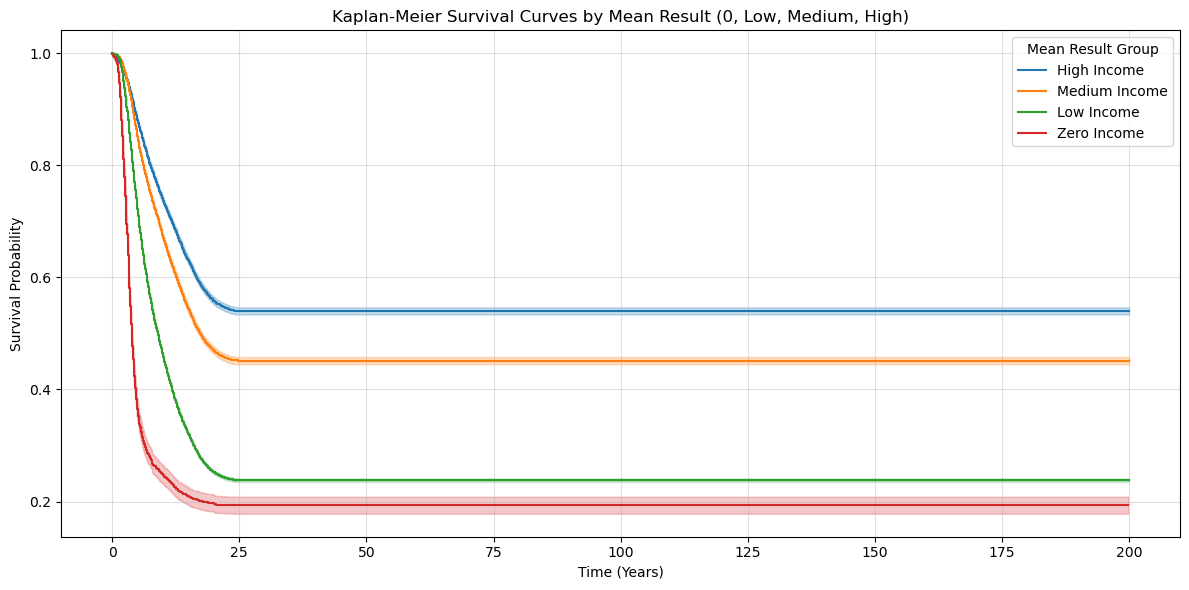

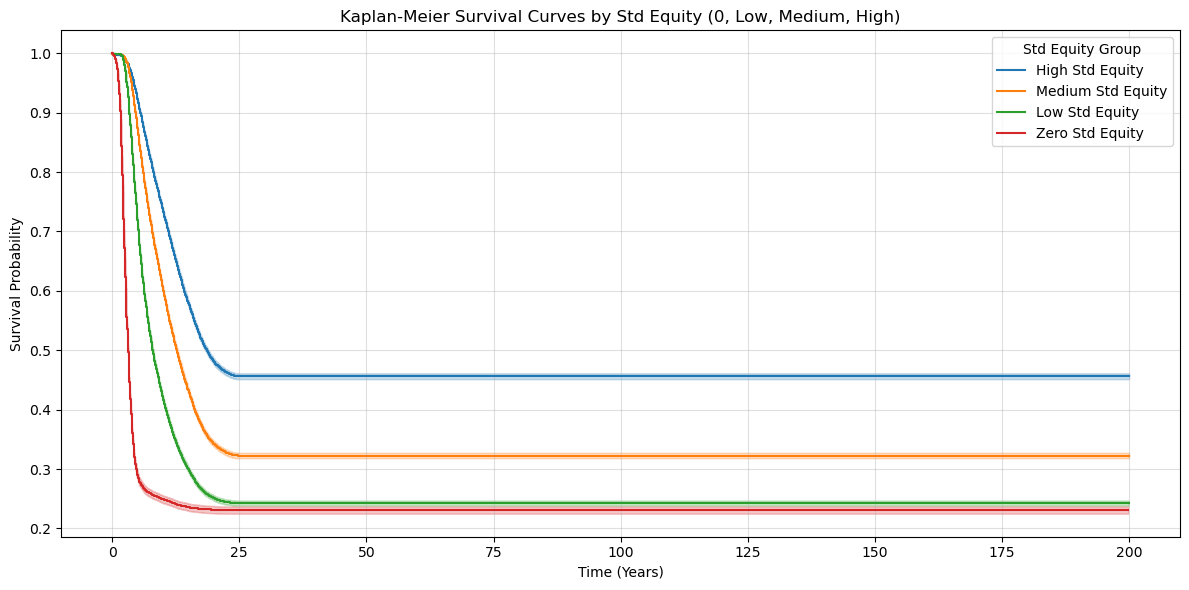

In [46]:
# Step 1: Create four groups for mean_result
# - 0: Separate category
# - Low, Medium, High: Quantile-based grouping
quantiles = cvr_df['mean_result'][cvr_df['mean_result'] > 0].quantile([0.33, 0.66]).values

def assign_mean_result_group(value):
    if value == 0:
        return 'Zero Income'
    elif value <= quantiles[0]:
        return 'Low Income'
    elif value <= quantiles[1]:
        return 'Medium Income'
    else:
        return 'High Income'

cvr_df['mean_result_group'] = cvr_df['mean_result'].apply(assign_mean_result_group)

# Step 2: Create similar groups for std_equity if needed
quantiles_equity = cvr_df['std_equity'][cvr_df['std_equity'] > 0].quantile([0.33, 0.66]).values

def assign_std_equity_group(value):
    if value == 0:
        return 'Zero Std Equity'
    elif value <= quantiles_equity[0]:
        return 'Low Std Equity'
    elif value <= quantiles_equity[1]:
        return 'Medium Std Equity'
    else:
        return 'High Std Equity'

cvr_df['std_equity_group'] = cvr_df['std_equity'].apply(assign_std_equity_group)

# Step 3: Drop rows with NaN values in relevant columns
columns_to_check = ['lifespan_years', 'event', 'mean_result', 'std_equity', 'mean_result_group', 'std_equity_group']
cvr_df_cleaned = cvr_df.dropna(subset=columns_to_check)

# Step 4: Kaplan-Meier analysis for mean_result_group
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

# Plot for mean_result_group
plt.figure(figsize=(12, 6))
for group in cvr_df_cleaned['mean_result_group'].unique():
    subset = cvr_df_cleaned[cvr_df_cleaned['mean_result_group'] == group]
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves by Mean Result (0, Low, Medium, High)")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.grid(True, alpha=0.4)
plt.legend(title="Mean Result Group")
plt.tight_layout()
plt.show()

# Plot for std_equity_group
plt.figure(figsize=(12, 6))
for group in cvr_df_cleaned['std_equity_group'].unique():
    subset = cvr_df_cleaned[cvr_df_cleaned['std_equity_group'] == group]
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves by Std Equity (0, Low, Medium, High)")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.grid(True, alpha=0.4)
plt.legend(title="Std Equity Group")
plt.tight_layout()
plt.show()


## 2.3 MODEL 3: Activity Metrics
Step 1: Preprocessing and Practical Considerations
For activity metrics, the key covariates include:

num_statement_submitters: Number of external entities submitting financial statements.
num_statements: Total number of financial statements submitted by the company.
Practical Considerations:
Missing Values: Inspect the extent of missing values. If a substantial proportion is missing, consider imputing or dropping rows.
Skewed Distribution: Activity metrics often have long tails. Apply log-transformation if needed to normalize the distribution.
Proportional Hazards Assumption: After fitting the model, test the assumption for each covariate.

In [59]:
# Step 1: Select relevant columns for Model 3
activity_columns = ['num_statement_submitters', 'num_statements', 'lifespan_years', 'event']
model_3_df = cvr_df[activity_columns].dropna()

# Step 2: Check for sufficient observations and events
print(f"Remaining rows after dropping missing values: {len(model_3_df)}")
print(f"Number of events (terminations): {model_3_df['event'].sum()}")

# Step 3: Check for skewness and normalize if needed
model_3_df['log_num_statement_submitters'] = np.log1p(model_3_df['num_statement_submitters'])  # log(1 + x)
model_3_df['log_num_statements'] = np.log1p(model_3_df['num_statements'])

# Debugging: Inspect data
model_3_df[['log_num_statement_submitters', 'log_num_statements', 'lifespan_years', 'event']].head()


Remaining rows after dropping missing values: 159430
Number of events (terminations): 109430


,log_num_statement_submitters,log_num_statements,lifespan_years,event
0,0.693147,1.609438,16.7,1
1,0.693147,1.609438,21.8,1
2,1.098612,1.609438,17.9,1
3,0.000000,1.609438,17.3,1
4,0.000000,1.609438,18.0,1


In [60]:
# Step 1: Initialize Cox Proportional Hazards model
cox_model_3 = CoxPHFitter()

# Step 2: Fit the model
cox_model_3.fit(model_3_df[['log_num_statement_submitters', 'log_num_statements', 'lifespan_years', 'event']], duration_col='lifespan_years', event_col='event')

# Step 3: Display summary
cox_model_3.print_summary()


<lifelines.CoxPHFitter: fitted with 159430 total observations, 50000 right-censored observations>
             duration col = 'lifespan_years'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 159430
number of events observed = 109430
   partial log-likelihood = -1244683.38
         time fit was run = 2024-12-20 12:09:21 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
log_num_statement_submitters -0.04      0.97      0.01           -0.05           -0.02                0.95                0.98
log_num_statements           -0.62      0.54      0.00           -0.63           -0.61                0.53                0.54

                              cmp to       z      p  -log2(p)
covariate                                                    
log_num_statement_submitters    0.00   -4.45 <0.005     16.80
log_num_statements              0.00 -150.11 <0.005       inf
---
Concordance = 0.75
Partial AIC = 2489370.76
log-likelihood ratio test = 29535.37 on 2 df
-log2(p) of ll-ratio test = inf

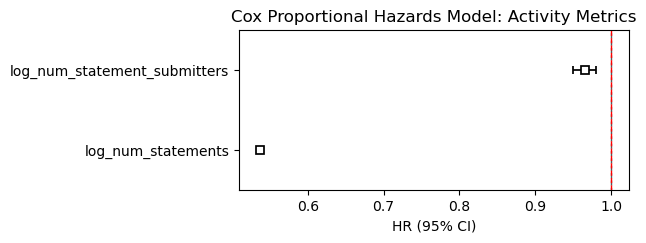

In [61]:

# Plot the results
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size for compactness
cox_model_3.plot(hazard_ratios=True, ax=ax)

# Customize the plot
plt.title("Cox Proportional Hazards Model: Activity Metrics", fontsize=12)
plt.xlabel("HR (95% CI)", fontsize=10)

# Adjust the Y-axis ticks and limits to reduce spacing
ax.set_ylim(-0.5, 1.5)  # Manually set tighter Y-axis limits
ax.set_yticks([0, 1])  # Force two specific tick positions for the two metrics

# Adjust layout to avoid whitespace
plt.tight_layout()
plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.1)

# Add a reference line at HR = 1
plt.axvline(1, color='red', linestyle='--', linewidth=1)
# Save the figure
plt.savefig("cox_model3_compact_boxes.jpg", bbox_inches='tight')

# Display the plot
plt.show()


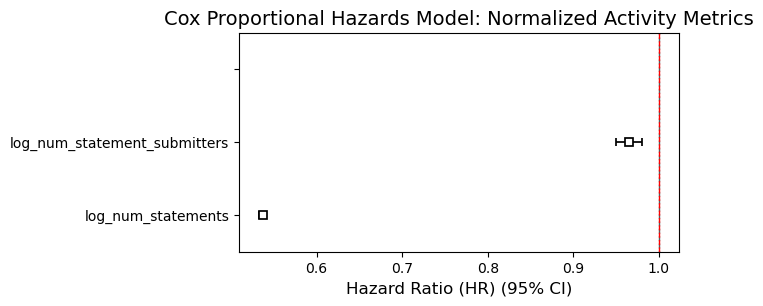

In [62]:
cox_model_data = model_3_df.copy()

# Normalize activity metrics (e.g., num_statements) by lifespan
cox_model_data['normalized_statements'] = cox_model_data['num_statements'] / cox_model_data['lifespan_years']

# Plot the results
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust figure size for better readability
cox_model_3.plot(hazard_ratios=True, ax=ax)

# Customize the plot
plt.title("Cox Proportional Hazards Model: Normalized Activity Metrics", fontsize=14)
plt.xlabel("Hazard Ratio (HR) (95% CI)", fontsize=12)

# Adjust the Y-axis ticks and limits for clarity
ax.set_ylim(-0.5, 2.5)  # Adjust Y-axis limits to fit more metrics if needed
ax.set_yticks([0, 1, 2])  # Add ticks for additional metrics, if present

# Add a reference line at HR = 1
plt.axvline(1, color='red', linestyle='--', linewidth=1)

# Adjust layout to minimize whitespace and optimize compactness
plt.tight_layout()
plt.subplots_adjust(left=0.4, right=0.95, top=0.88, bottom=0.15)

# Save the figure
plt.savefig("cox_model3_normalized_metrics.jpg", bbox_inches='tight', dpi=300)

# Display the plot
plt.show()


In [63]:
# Combine all covariates for the general model
general_columns = [
    'industry_mainCategory', 'company_type', 'number_of_names',  # Structural factors
    'mean_equity', 'mean_result', 'mean_staff_expenses', 'std_equity', 'std_result',  # Financial metrics
    'num_statement_submitters', 'num_statements'  # Activity metrics
]

# Drop rows with missing values for selected covariates and required columns
general_model_df = cvr_df.dropna(subset=general_columns + ['lifespan_years', 'event'])

# Normalize financial and activity metrics (log transformation for skewed variables)
for col in ['mean_equity', 'mean_result', 'mean_staff_expenses', 'std_equity', 'std_result', 'num_statements']:
    general_model_df[f'log_{col}'] = general_model_df[col].apply(lambda x: np.log(x + 1))  # Add 1 to avoid log(0)

# Encode categorical variables
general_model_df = pd.get_dummies(general_model_df, columns=['industry_mainCategory', 'company_type'], drop_first=True)

# Ensure sufficient observations
print(f"Remaining rows after preprocessing: {len(general_model_df)}")
print(f"Number of events (terminations): {general_model_df['event'].sum()}")


Remaining rows after preprocessing: 43206
Number of events (terminations): 30014


ValueError: Values must be numeric: no strings, datetimes, objects, etc.

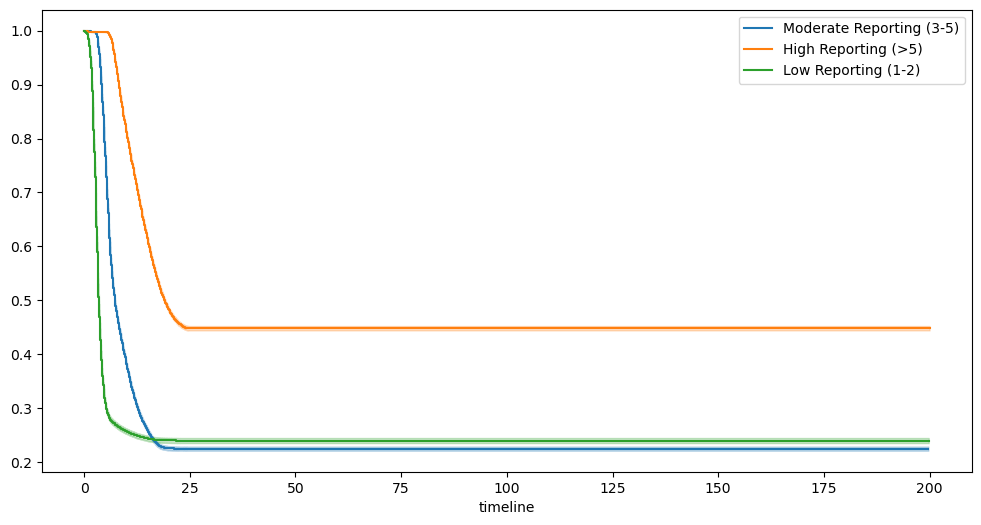

In [64]:
# Group based on num_statements thresholds
cvr_df['num_statements_group'] = pd.cut(
    cvr_df['num_statements'],
    bins=[0, 2, 5, np.inf],
    labels=['Low Reporting (1-2)', 'Moderate Reporting (3-5)', 'High Reporting (>5)']
)

# Kaplan-Meier analysis
plt.figure(figsize=(12, 6))
for group in cvr_df['num_statements_group'].unique():
    subset = cvr_df[cvr_df['num_statements_group'] == group]
    kmf.fit(durations=subset['lifespan_years'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curves by Number of Financial Statements")
plt.xlabel("Time (Years)")
plt.ylabel("Survival Probability")
plt.grid(True, alpha=0.4)
plt.legend(title="Num Statements Group")
plt.tight_layout()
plt.show()


# 3. Statistically Compare Survival Patterns Across Industries and Company Types Using Log-Rank

- statistically compare survival patterns across industries and company types using a dataset of both active and dissolved companies.

#### 3. Comparative Analysis Using Log-Rank Test -  it is a type of hypothesis test used in survival analysis

It tests the null hypothesis (H₀) that there is no difference in survival times between the groups.
A single-variable log-rank test is typically used for categorical group comparisons (e.g., survival differences between industries).

I would start with a global test (e.g., comparing all categories) to determine if significant differences exist. If the global test is significant, follow up with pairwise comparisons to understand where those differences lie.

So for global test p<0.05 is typically appropriate, as it evaluates the overall differences across all groups. 

**Goal:** Statistically compare survival probabilities across groups (e.g., industries or company types) to identify significant differences.

**Method:**
- Apply the log-rank test to Kaplan–Meier curves to test whether survival distributions differ significantly between categories.
- Use p-values to identify statistically significant differences.



## 3.1 Focus on Global Comparisons
Global Test (p < 0.05):

A global test is ideal for evaluating whether survival probabilities differ significantly across all groups.
If significant, it indicates that at least one group differs but does not specify which.


In [65]:
# Perform a global test for all industry categories
global_test = multivariate_logrank_test(
    cvr_df['lifespan_months'], 
    cvr_df['industry_mainCategory'], 
    cvr_df['is_terminated']
)
print(global_test)


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 19
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        8297.42 <0.005       inf


## 3.2 Pairwise Comparisons

Pairwise Comparisons (Bonferroni Correction):



In [66]:
# Pairwise log-rank tests for industries
unique_categories = cvr_df['industry_mainCategory'].unique()
pairwise_results = []

for group1, group2 in combinations(unique_categories, 2):
    subset1 = cvr_df[cvr_df['industry_mainCategory'] == group1]
    subset2 = cvr_df[cvr_df['industry_mainCategory'] == group2]
    
    # Log-rank test
    results = logrank_test(
        subset1['lifespan_months'], subset2['lifespan_months'], 
        event_observed_A=subset1['is_terminated'], event_observed_B=subset2['is_terminated']
    )
    pairwise_results.append((group1, group2, results.p_value))

# Convert to DataFrame for easy readability
pairwise_df = pd.DataFrame(pairwise_results, columns=['Group 1', 'Group 2', 'P-value'])
pairwise_df

,Group 1,Group 2,P-value
0,Information og kommunikation,Engroshandel og detailhandel; reparation af mo...,4.467563e-19
1,Information og kommunikation,Fremstillingsvirksomhed,2.503941e-03
2,Information og kommunikation,"Liberale, videnskabelige og tekniske tjenestey...",9.734028e-22
3,Information og kommunikation,Bygge- og anlægsvirksomhed,1.253511e-01
4,Information og kommunikation,Fast ejendom,3.378068e-156
...,...,...,...
185,Undervisning,Offentlig forvaltning og forsvar; socialsikring,2.687451e-02
186,Undervisning,Private husholdninger med ansat medhjælp; hush...,6.317184e-01
187,"Landbrug, jagt, skovbrug og fiskeri",Offentlig forvaltning og forsvar; socialsikring,5.226901e-03
188,"Landbrug, jagt, skovbrug og fiskeri",Private husholdninger med ansat medhjælp; hush...,8.444657e-02


In [67]:
'''Adjust p-values with Bonferroni'''

#pairwise_df['Adjusted P-value'] = pairwise_df['P-value'] * len(pairwise_df)
#pairwise_df['Significant'] = pairwise_df['Adjusted P-value'] < 0.05
#pairwise_df


'''Adjust p-values using Benjamini-Hochberg (FDR)'''



# Check if 'P-value' column exists in pairwise_df
if 'P-value' not in pairwise_df.columns:
    raise KeyError("The column 'P-value' is missing from the pairwise_df.")

# Extract raw p-values from the DataFrame
raw_p_values = pairwise_df['P-value'].values  # Ensure you're accessing it as an array

# Apply Benjamini-Hochberg FDR adjustment
adjusted_p_values = multipletests(raw_p_values, method='fdr_bh')[1]

# Add the adjusted p-values back to the DataFrame
pairwise_df['Adjusted P-value'] = adjusted_p_values

# Mark significant results based on adjusted p-values
pairwise_df['Significant'] = pairwise_df['Adjusted P-value'] < 0.05

# Display the adjusted results
pairwise_df


,Group 1,Group 2,P-value,Adjusted P-value,Significant
0,Information og kommunikation,Engroshandel og detailhandel; reparation af mo...,4.467563e-19,1.664386e-18,True
1,Information og kommunikation,Fremstillingsvirksomhed,2.503941e-03,4.364668e-03,True
2,Information og kommunikation,"Liberale, videnskabelige og tekniske tjenestey...",9.734028e-22,3.853053e-21,True
3,Information og kommunikation,Bygge- og anlægsvirksomhed,1.253511e-01,1.642532e-01,False
4,Information og kommunikation,Fast ejendom,3.378068e-156,3.056348e-155,True
...,...,...,...,...,...
185,Undervisning,Offentlig forvaltning og forsvar; socialsikring,2.687451e-02,4.020596e-02,True
186,Undervisning,Private husholdninger med ansat medhjælp; hush...,6.317184e-01,6.631299e-01,False
187,"Landbrug, jagt, skovbrug og fiskeri",Offentlig forvaltning og forsvar; socialsikring,5.226901e-03,8.788594e-03,True
188,"Landbrug, jagt, skovbrug og fiskeri",Private husholdninger med ansat medhjælp; hush...,8.444657e-02,1.179768e-01,False


#### 3.1.2 Heatmap of P-values

In [68]:
import pandas as pd
import numpy as np

# Step 1: Get unique groups
unique_groups = pd.unique(pairwise_df[['Group 1', 'Group 2']].values.ravel())

# Step 2: Initialize an empty DataFrame
heatmap_data = pd.DataFrame(index=unique_groups, columns=unique_groups, data=np.nan)

# Step 3: Fill the DataFrame
for _, row in pairwise_df.iterrows():
    group1 = row['Group 1']
    group2 = row['Group 2']
    p_value = row['Adjusted P-value']  # Or use 'P-value' if unadjusted is desired

    # Fill both [group1][group2] and [group2][group1] for symmetry
    heatmap_data.loc[group1, group2] = p_value
    heatmap_data.loc[group2, group1] = p_value

# Replace NaN with a placeholder (optional, depends on your visualization preferences)
heatmap_data.fillna(1, inplace=True)  # Replace missing values with 1 (non-significant)


<Figure size 640x480 with 0 Axes>

In [70]:
heatmap_data

,Information og kommunikation,Engroshandel og detailhandel; reparation af motorkøretøjer og motorcykler,Fremstillingsvirksomhed,"Liberale, videnskabelige og tekniske tjenesteydelser",Bygge- og anlægsvirksomhed,Fast ejendom,"Pengeinstitut- og finansvirksomhed, forsikring","El-, gas- og fjernvarmeforsyning",Eksterritoriale organisationer og organer,Andre serviceydelser,Administrative tjenesteydelser og hjælpetjenester,Overnatningsfaciliteter og restaurationsvirksomhed,Transport og godshåndtering,Sundhedsvæsen og sociale foranstaltninger,"Vandforsyning; kloakvæsen, affaldshåndtering og rensning af jord og grundvand","Kultur, forlystelser og sport",Undervisning,"Landbrug, jagt, skovbrug og fiskeri",Offentlig forvaltning og forsvar; socialsikring,"Private husholdninger med ansat medhjælp; husholdningers produktion af varer og tjenesteydelser til eget brug, i.a.n."
Information og kommunikation,1.000000e+00,1.664386e-18,4.364668e-03,3.853053e-21,1.642532e-01,3.056348e-155,3.346586e-117,2.962223e-12,0.000000e+00,6.430175e-01,2.759402e-05,7.177350e-34,6.042360e-01,4.500922e-14,2.386961e-03,4.956431e-01,4.935591e-01,1.275815e-01,1.117230e-02,0.618384
Engroshandel og detailhandel; reparation af motorkøretøjer og motorcykler,1.664386e-18,1.000000e+00,7.280740e-29,6.593981e-102,4.057089e-15,0.000000e+00,0.000000e+00,2.146836e-20,0.000000e+00,3.283066e-06,2.386961e-03,4.257235e-10,5.590756e-08,4.430780e-35,1.725771e-06,6.686649e-06,1.154449e-02,7.649948e-02,6.133418e-02,0.729043
Fremstillingsvirksomhed,4.364668e-03,7.280740e-29,1.000000e+00,2.288425e-07,1.278651e-05,7.950377e-99,6.034013e-60,1.306884e-09,0.000000e+00,3.109107e-01,2.440998e-11,5.637175e-43,7.901863e-03,2.554760e-08,1.904075e-02,4.660982e-01,4.423975e-02,1.547730e-01,3.995485e-03,0.532341
"Liberale, videnskabelige og tekniske tjenesteydelser",3.853053e-21,6.593981e-102,2.288425e-07,1.000000e+00,1.716695e-32,1.730659e-81,3.005308e-46,1.934907e-06,0.000000e+00,6.582789e-05,9.469537e-42,2.263321e-100,3.570709e-13,3.863987e-03,2.167248e-01,5.503530e-04,4.759521e-06,2.031000e-01,4.075640e-04,0.406443
Bygge- og anlægsvirksomhed,1.642532e-01,4.057089e-15,1.278651e-05,1.716695e-32,1.000000e+00,2.428533e-194,3.850570e-171,2.664809e-13,0.000000e+00,2.554069e-01,2.745236e-03,2.686161e-30,6.492367e-01,4.806774e-17,8.649316e-04,1.813816e-01,8.664225e-01,1.225518e-01,1.943288e-02,0.643018
Fast ejendom,3.056348e-155,0.000000e+00,7.950377e-99,1.730659e-81,2.428533e-194,1.000000e+00,2.965705e-18,9.701687e-01,0.000000e+00,5.059858e-41,6.356812e-190,4.303122e-275,3.399685e-91,2.642359e-11,1.804048e-02,1.710892e-34,8.353376e-36,4.614907e-01,9.262553e-08,0.156960
"Pengeinstitut- og finansvirksomhed, forsikring",3.346586e-117,0.000000e+00,6.034013e-60,3.005308e-46,3.850570e-171,2.965705e-18,1.000000e+00,7.223898e-02,0.000000e+00,5.008551e-20,5.165992e-149,4.061178e-230,3.127119e-53,1.117230e-02,4.861079e-01,3.013063e-16,3.123955e-18,3.668384e-01,8.130174e-05,0.286263
"El-, gas- og fjernvarmeforsyning",2.962223e-12,2.146836e-20,1.306884e-09,1.934907e-06,2.664809e-13,9.701687e-01,7.223898e-02,1.000000e+00,1.620849e-179,5.174547e-09,7.027487e-16,1.272620e-23,2.553354e-11,3.995485e-03,7.649948e-02,1.044252e-08,4.572822e-10,4.614907e-01,2.123963e-06,0.181950
Eksterritoriale organisationer og organer,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.620849e-179,1.000000e+00,5.331080e-206,1.046755e-309,9.644978e-134,2.149535e-275,0.000000e+00,7.284290e-89,9.539746e-180,1.688663e-144,5.590756e-08,1.506882e-02,0.585347
Andre serviceydelser,6.430175e-01,3.283066e-06,3.109107e-01,6.582789e-05,2.554069e-01,5.059858e-41,5.008551e-20,5.174547e-09,5.331080e-206,1.000000e+00,8.083912e-03,4.332104e-12,5.090981e-01,6.521995e-07,1.060100e-02,8.002338e-01,3.959861e-01,1.531434e-01,2.231881e-02,0.628746


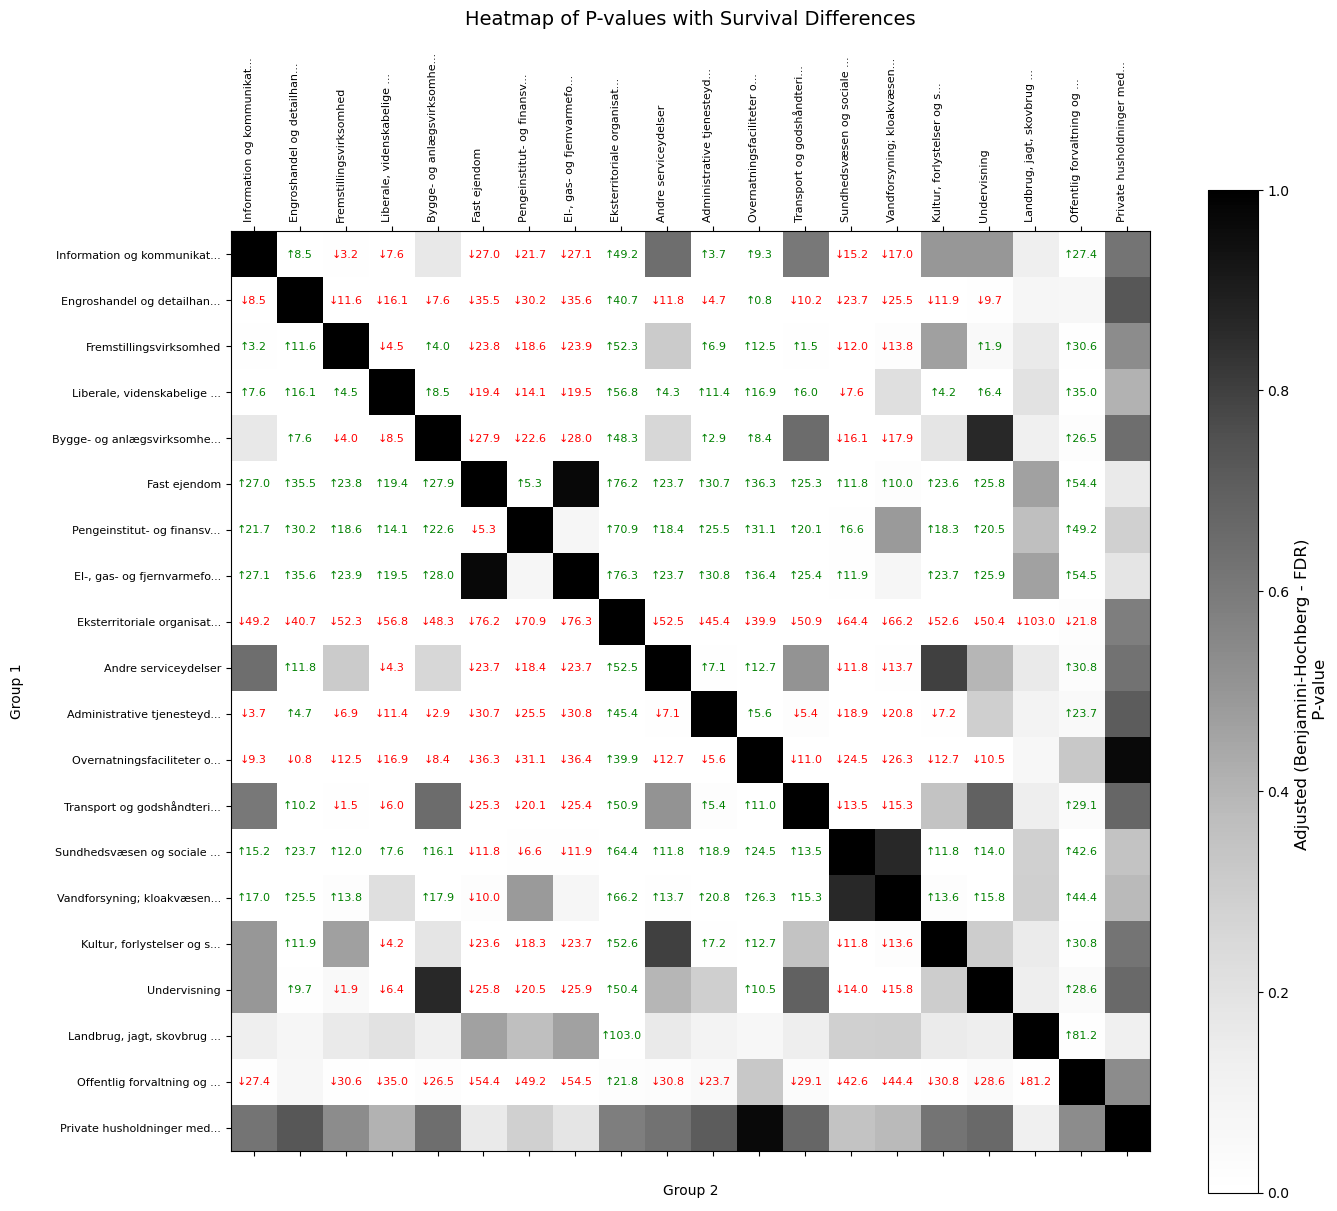

In [69]:

# Assume you have a dictionary of average survival rates by industry
average_survival_rates = cvr_df.groupby('industry_mainCategory')['lifespan_years'].mean()

# Calculate pairwise differences in survival rates
survival_rate_diff = heatmap_data.copy()
for i, group1 in enumerate(heatmap_data.index):
    for j, group2 in enumerate(heatmap_data.columns):
        if group1 != group2:
            survival_rate_diff.loc[group1, group2] = (
                average_survival_rates[group1] - average_survival_rates[group2]
            )
        else:
            survival_rate_diff.loc[group1, group2] = np.nan  # Diagonal is not needed

# Create a combined heatmap
fig, ax = plt.subplots(figsize=(14, 14))

# Plot the adjusted p-values heatmap
cax = ax.matshow(heatmap_data, cmap='Greys', vmin=0, vmax=1)

# Overlay survival rate differences using annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        p_value = heatmap_data.iloc[i, j]
        survival_diff = survival_rate_diff.iloc[i, j]
        
        # Only annotate for significant p-values
        if p_value < 0.05:
            if survival_diff > 0:
                ax.text(j, i, f'↑{survival_diff:.1f}', ha='center', va='center', fontsize=8, color='green')  # Higher survival
            elif survival_diff < 0:
                ax.text(j, i, f'↓{abs(survival_diff):.1f}', ha='center', va='center', fontsize=8, color='red')  # Lower survival

# Customize ticks and labels
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_yticks(range(len(heatmap_data.index)))

# Adjust long labels by wrapping or abbreviating them
short_labels_x = [label[:25] + '...' if len(label) > 25 else label for label in heatmap_data.columns]
short_labels_y = [label[:25] + '...' if len(label) > 25 else label for label in heatmap_data.index]

ax.set_xticklabels(short_labels_x, rotation=90, ha='right', fontsize=8)  # Rotate for clarity
ax.set_yticklabels(short_labels_y, fontsize=8)

# Add colorbar with adjusted size
cbar = fig.colorbar(cax, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Adjusted (Benjamini-Hochberg - FDR) \n P-value', fontsize=12)

# Add labels and title
plt.title('Heatmap of P-values with Survival Differences', fontsize=14, pad=20)
plt.xlabel('Group 2', fontsize=10, labelpad=20)
plt.ylabel('Group 1', fontsize=10, labelpad=20)

# Adjust layout for readability
plt.tight_layout()
plt.savefig("LogRankMatrix.jpg", bbox_inches='tight')
plt.savefig("heatmap.jpg", bbox_inches='tight', dpi=300)  # Save as .jpg
# Show the plot
plt.show()


In [ ]:

# Assume you have a dictionary of average survival rates by industry
average_survival_rates = cvr_df.groupby('industry_mainCategory')['lifespan_years'].mean()

# Calculate pairwise differences in survival rates
survival_rate_diff = heatmap_data.copy()
for i, group1 in enumerate(heatmap_data.index):
    for j, group2 in enumerate(heatmap_data.columns):
        if group1 != group2:
            survival_rate_diff.loc[group1, group2] = (
                average_survival_rates[group1] - average_survival_rates[group2]
            )
        else:
            survival_rate_diff.loc[group1, group2] = np.nan  # Diagonal is not needed

# Create a combined heatmap
fig, ax = plt.subplots(figsize=(14, 14))

# Plot the adjusted p-values heatmap
cax = ax.matshow(heatmap_data, cmap='Greys', vmin=0, vmax=1)



# Customize ticks and labels
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_yticks(range(len(heatmap_data.index)))

# Adjust long labels by wrapping or abbreviating them
short_labels_x = [label[:25] + '...' if len(label) > 25 else label for label in heatmap_data.columns]
short_labels_y = [label[:25] + '...' if len(label) > 25 else label for label in heatmap_data.index]

ax.set_xticklabels(short_labels_x, rotation=90, ha='right', fontsize=12)  # Rotate for clarity
ax.set_yticklabels(short_labels_y, fontsize=12)

# Add colorbar with adjusted size
cbar = fig.colorbar(cax, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Adjusted (Benjamini-Hochberg - FDR) \n P-value', fontsize=12)

# Add labels and title
plt.title('Heatmap of P-values with Survival Differences', fontsize=14, pad=20)
plt.xlabel('Group 2', fontsize=10, labelpad=20)
plt.ylabel('Group 1', fontsize=10, labelpad=20)

# Adjust layout for readability
plt.tight_layout()
plt.savefig("LogRankMatrix.jpg", bbox_inches='tight')
# Show the plot
plt.show()
